In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

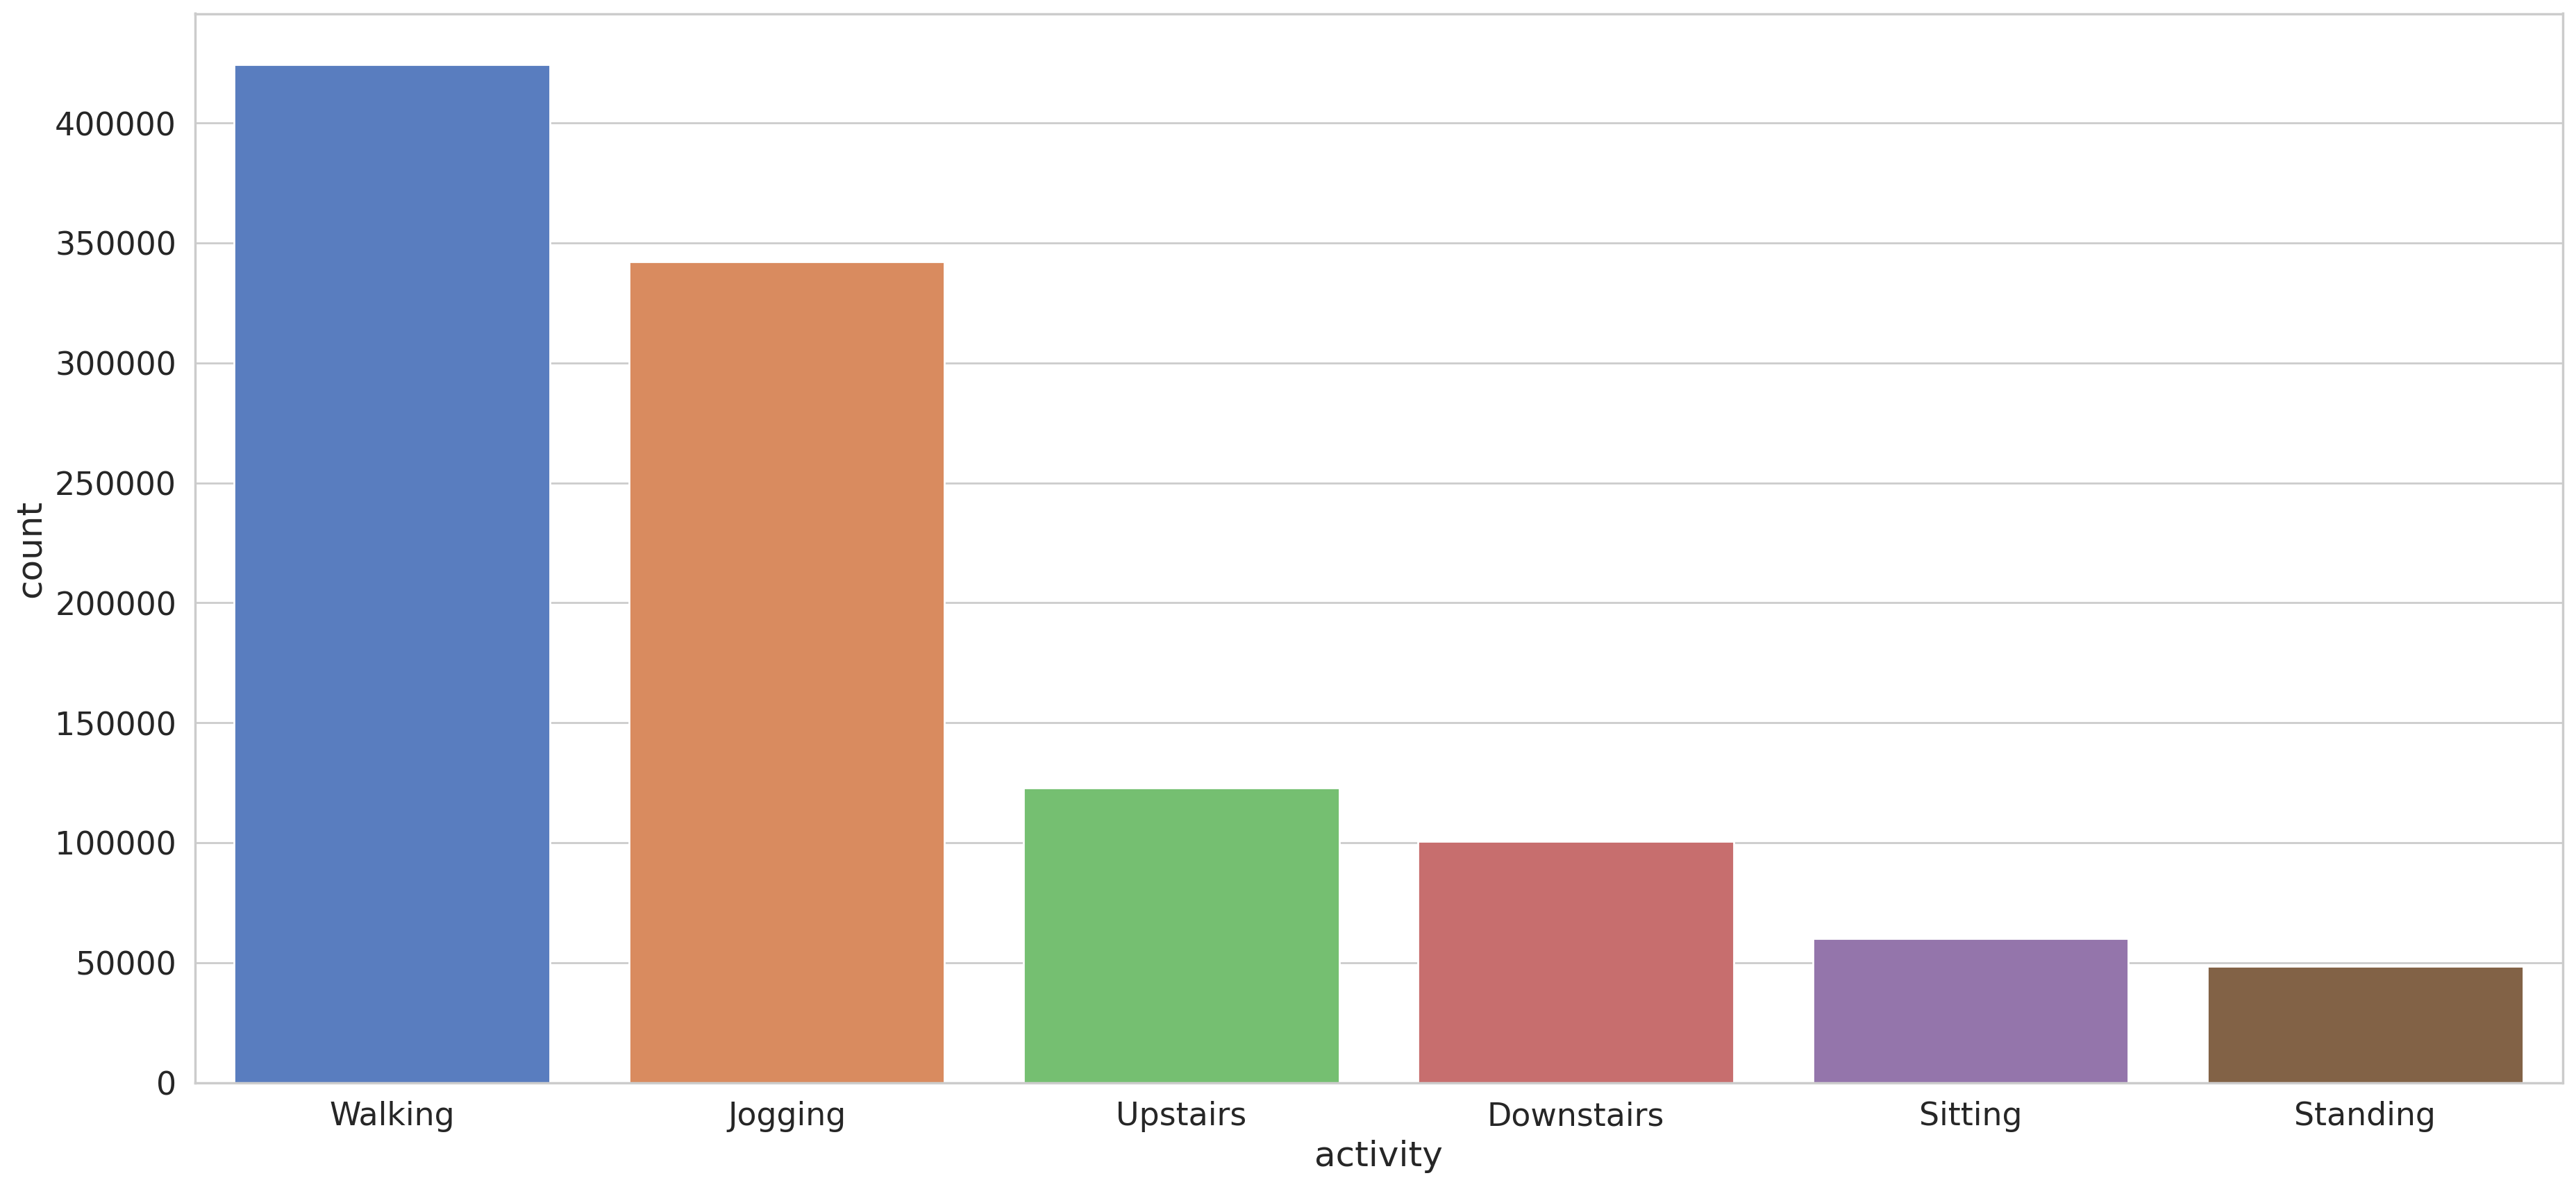

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

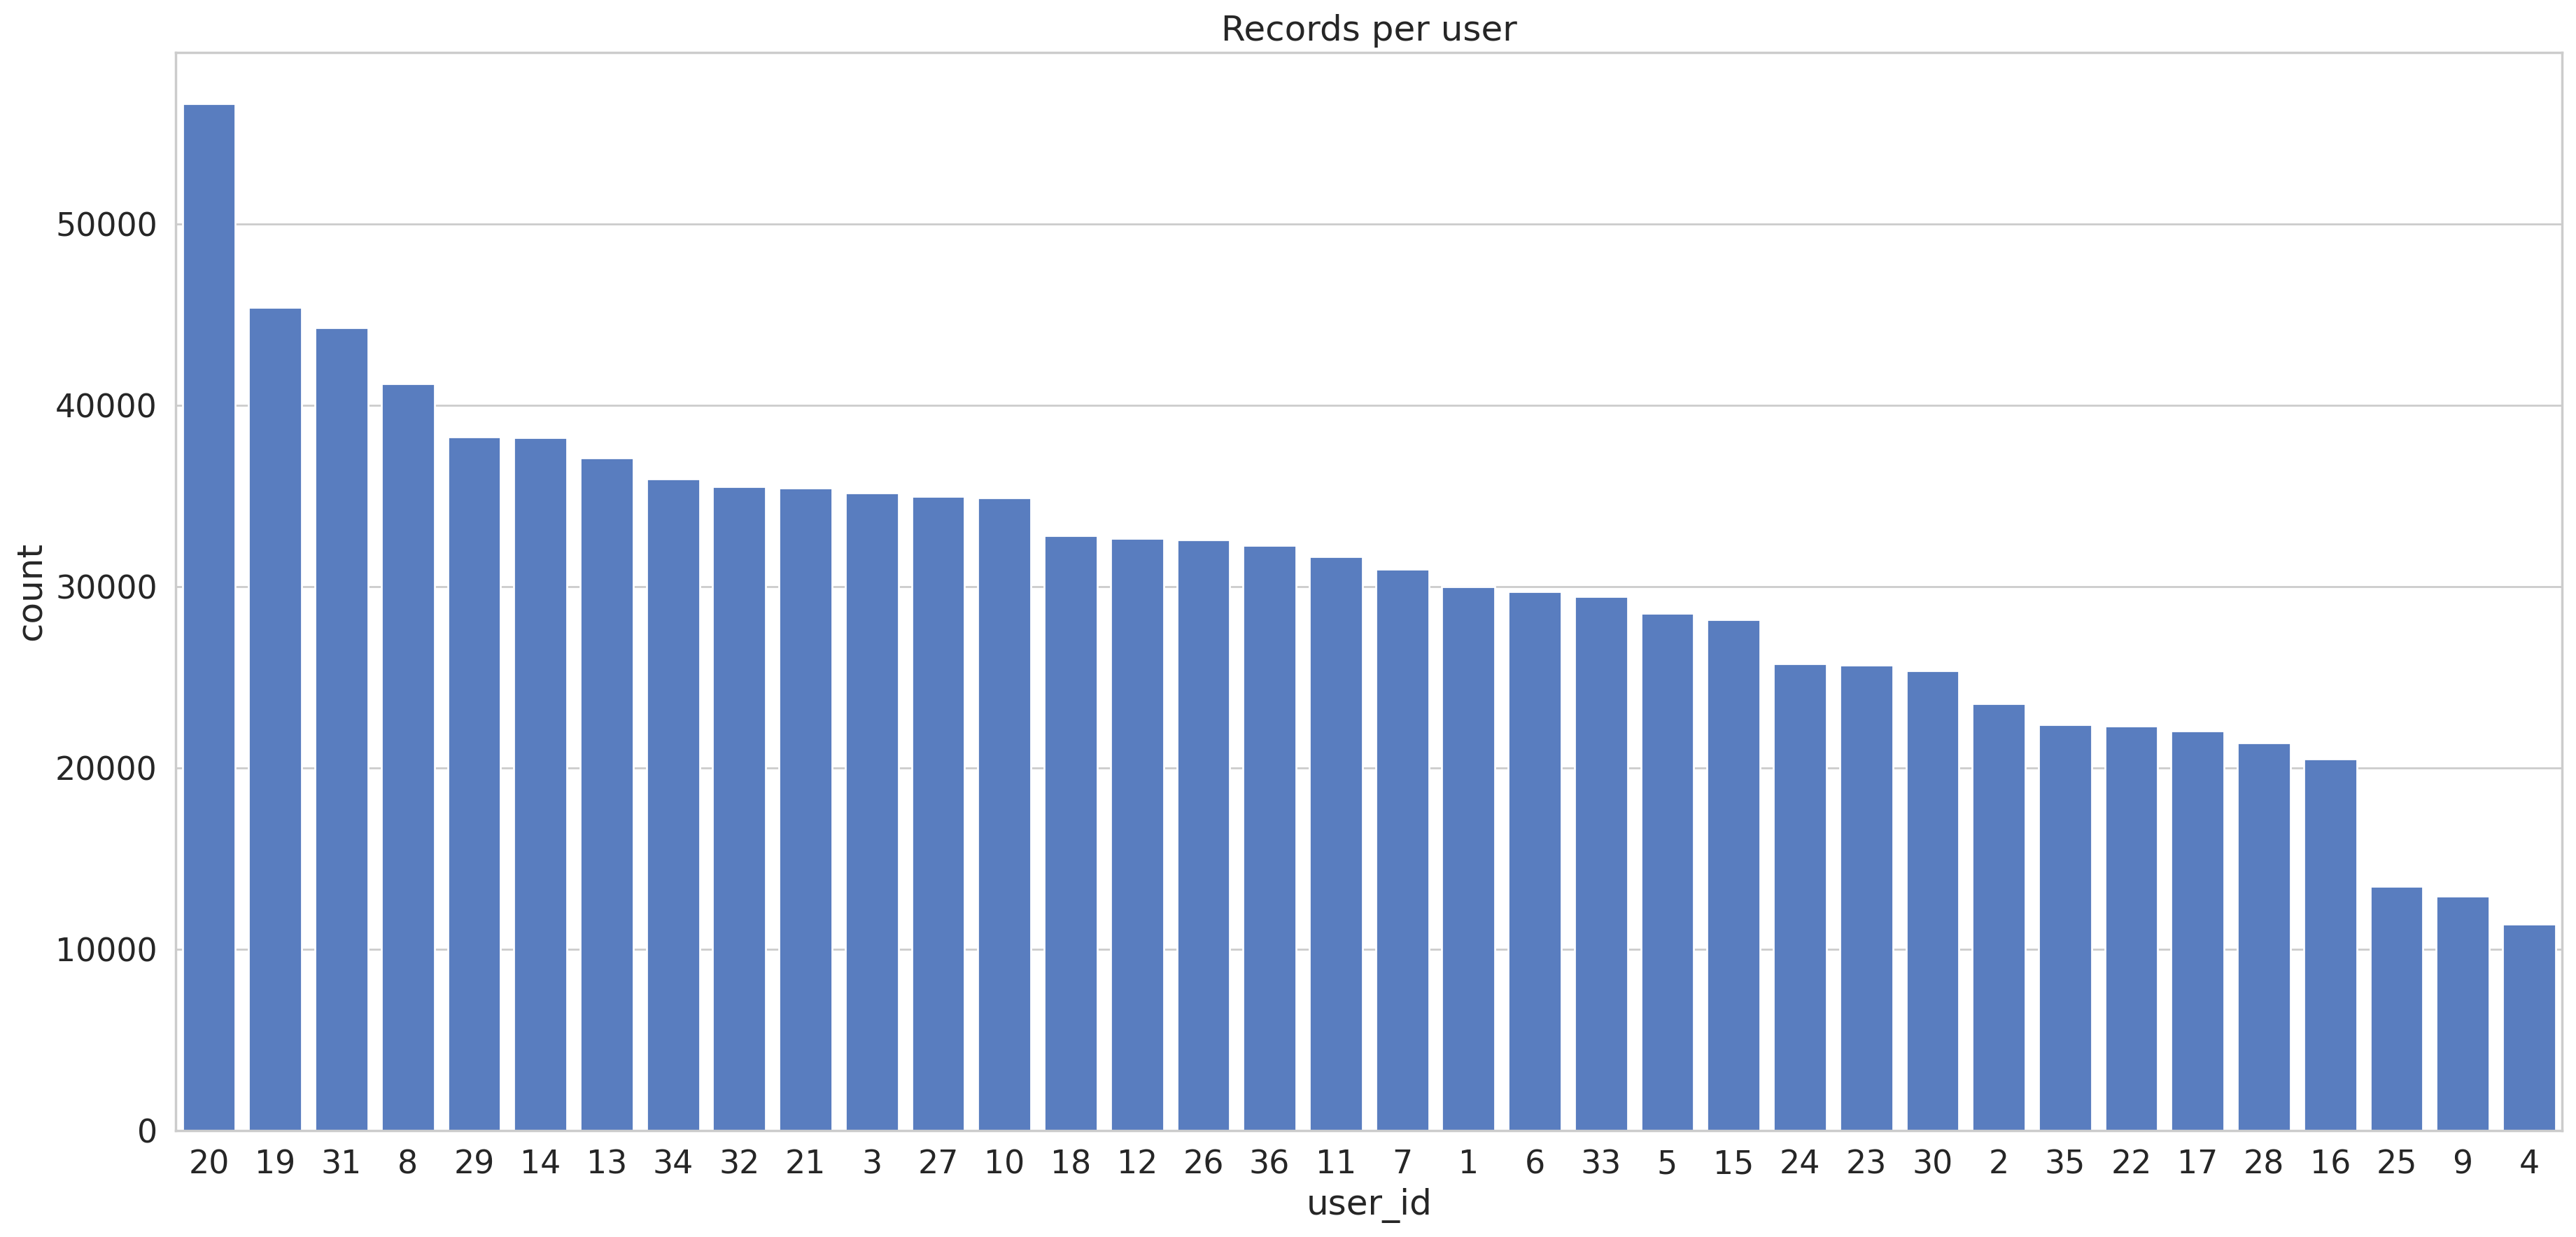

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


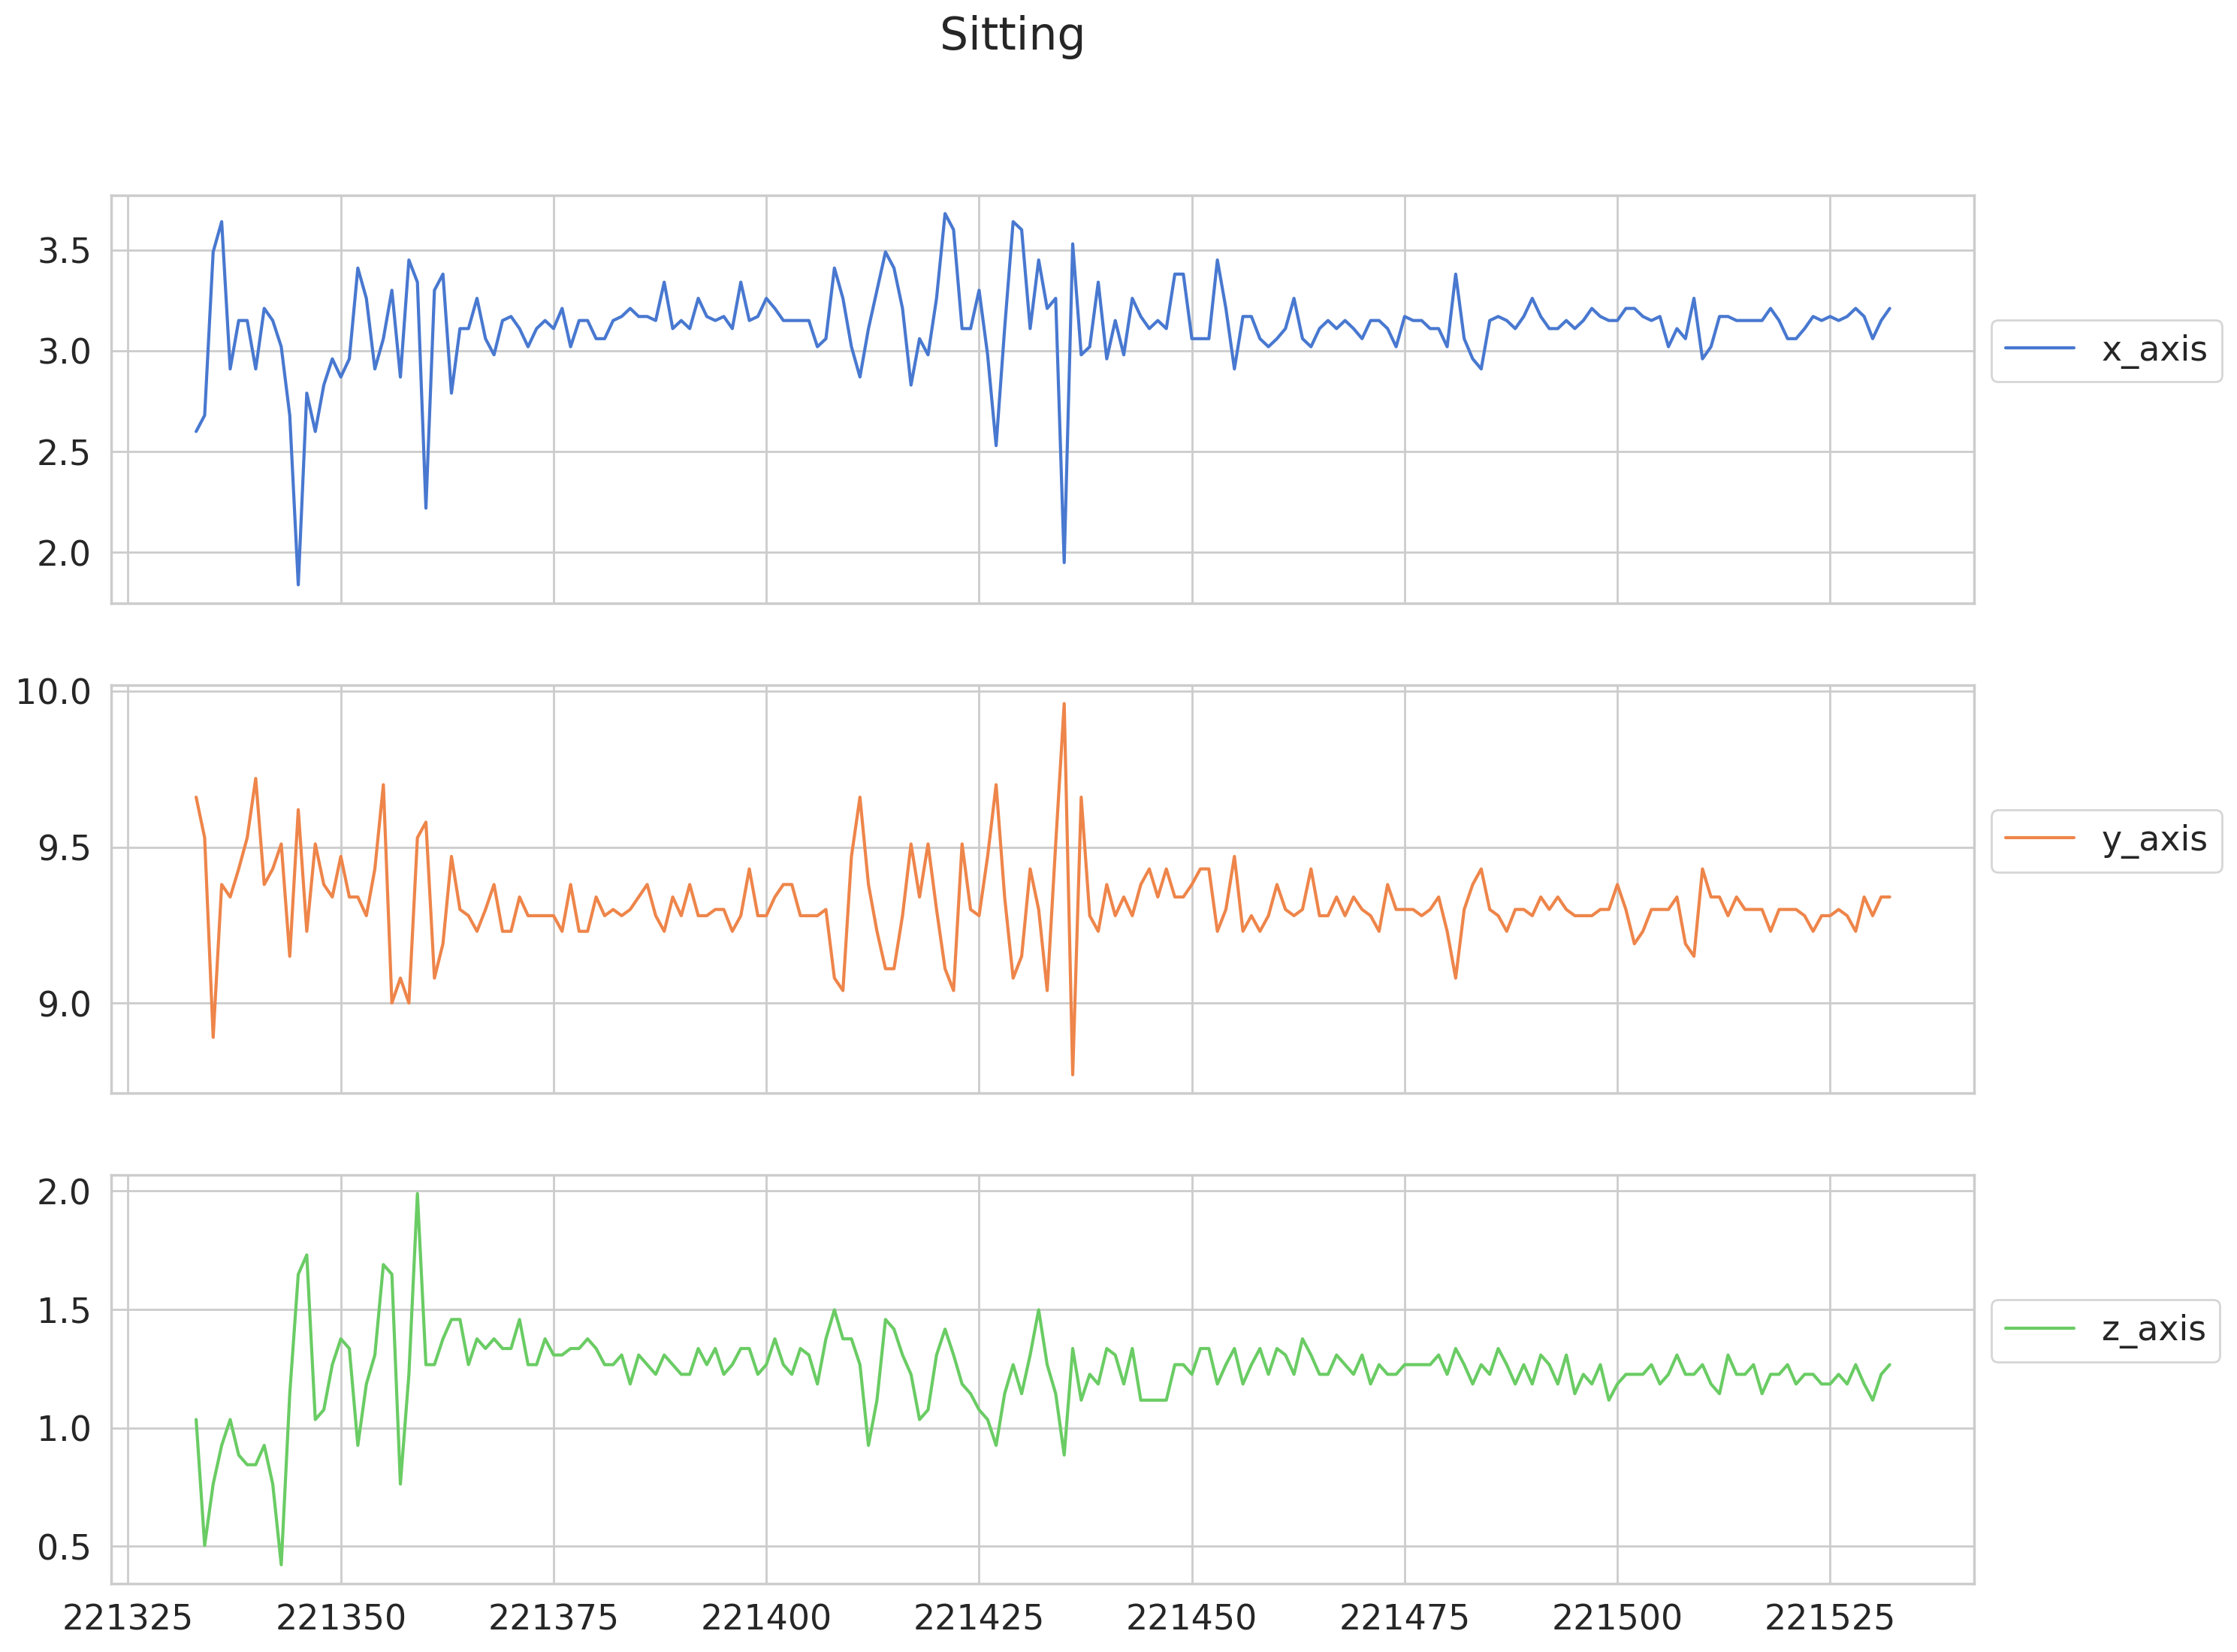

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)


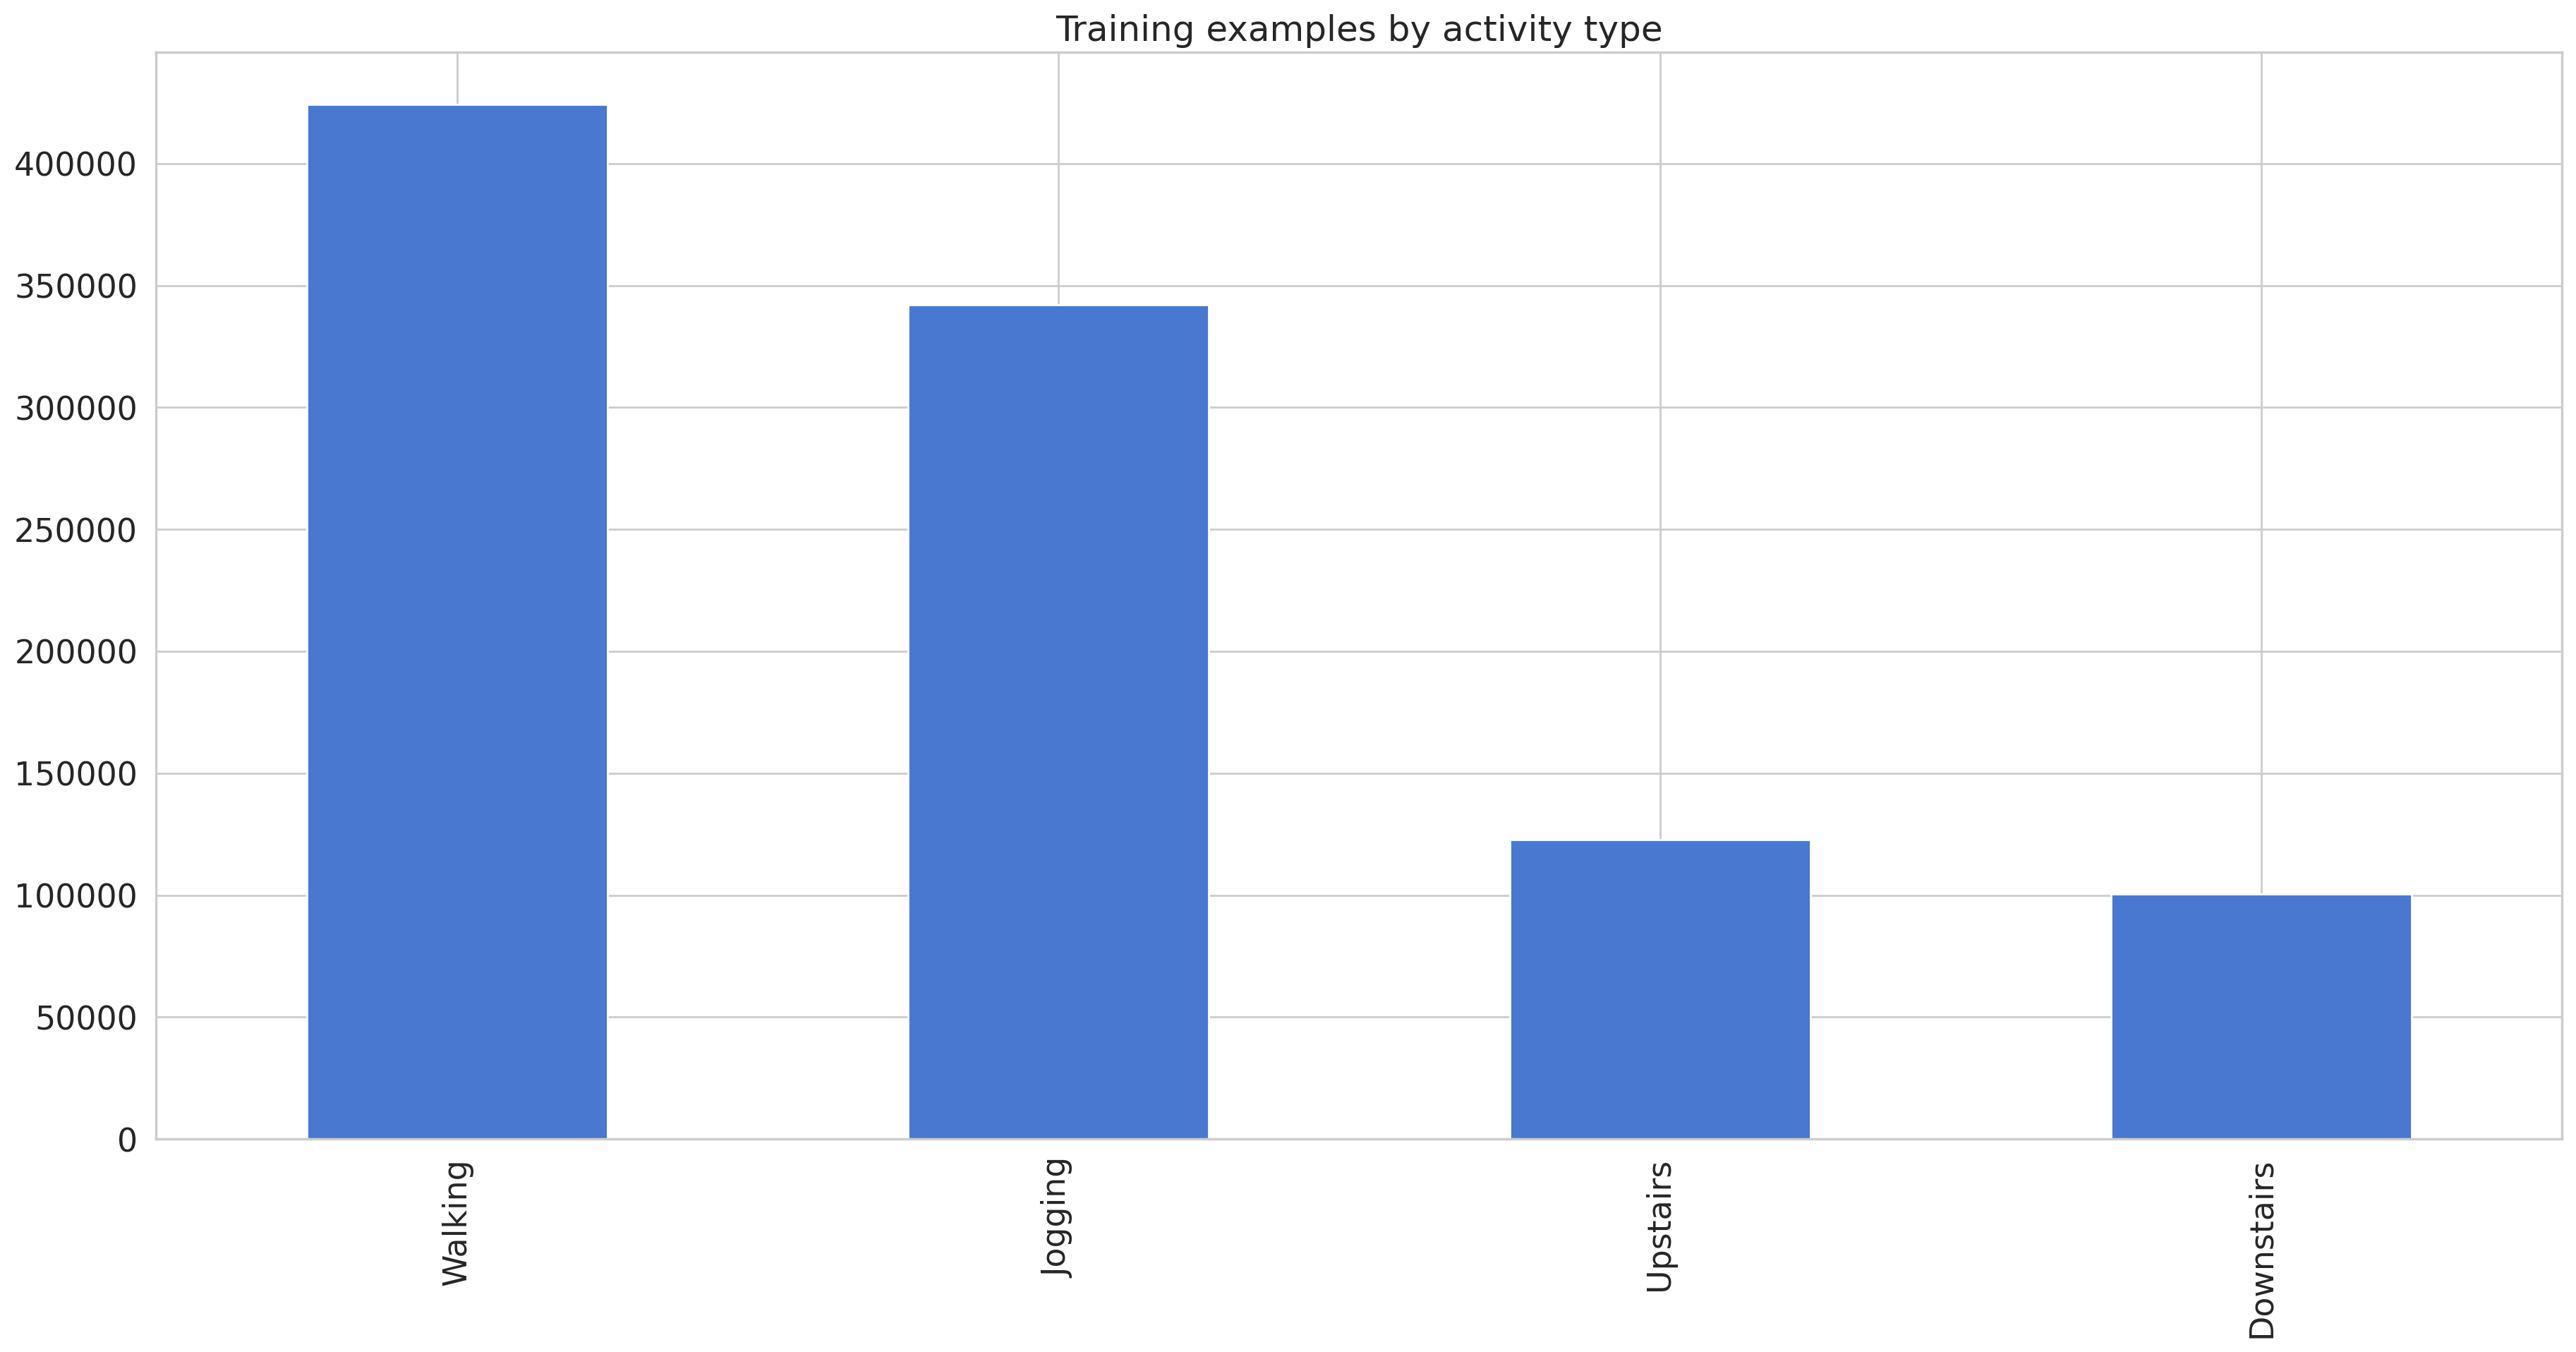

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id    activity        timestamp    x_axis    y_axis    z_axis  \
0             33     Jogging   49105962326000 -0.139064  0.528798  0.162904   
1             33     Jogging   49106062271000  0.627996  0.365980  0.257510   
2             33     Jogging   49106112167000  0.613350  0.322145  0.039629   
3             33     Jogging   49106222305000 -0.128080  1.197291  0.693271   
4             33     Jogging   49106332290000 -0.204969  0.463045  1.573395   
...          ...         ...              ...       ...       ...       ...   
1093534       19  Downstairs  131357151521000 -0.602151 -0.017241  0.635659   
1093535       19  Downstairs  131357191438000 -0.987903  0.155172  0.248370   
1093536       19  Downstairs  131357231630000 -1.235215  0.718391  0.119975   
1093537       19  Downstairs  131357271516000 -1.065860  0.026437 -0.524103   
1093538       19  Downstairs  131357351686000 -0.977151 -0.510345 -0.103137   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1093534                3  
1093535                3  
1093536                3  
1093537                3  
1093538                3  

[989870 rows x 7 columns]

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63348, 50, 3) (63348, 1)
(19797, 50, 3) (19797, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(63348, 50, 3) (63348, 4) (19797, 50, 3) (19797, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 4)

# LSTM1


In [15]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 59588 (232.77 KB)
Trainable params: 59588 (232.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
62/62 [==============================] - 23s 344ms/step - loss: 1.0307 - accuracy: 0.6133 - val_loss: 0.7048 - val_accuracy: 0.7476
Epoch 2/10
62/62 [==============================] - 22s 348ms/step - loss: 0.6439 - accuracy: 0.7636 - val_loss: 0.6061 - val_accuracy: 0.7719
Epoch 3/10
62/62 [==============================] - 21s 333ms/step - loss: 0.5715 - accuracy: 0.7830 - val_loss: 0.4832 - val_accuracy: 0.8073
Epoch 4/10
62/62 [==============================] - 22s 354ms/step - loss: 0.4377 - accuracy: 0.8251 - val_loss: 0.4002 - val_accuracy: 0.8364
Epoch 5/10
62/62 [==============================] - 20s 324ms/step - loss: 0.3853 - accuracy: 0.8435 - val_loss: 0.3585 - val_accuracy: 0.8570
Epoch 6/10
62/62 [==============================] - 21s 337ms/step - loss: 0.3458 - accuracy: 0.8571 - val_loss: 0.3238 - val_accuracy: 0.8665
Epoch 7/10
62/62 [==============================] - 21s 337ms/step - loss: 0.3179 - accuracy: 0.8667 - val_loss: 0.2950 - val_accuracy: 0.8812

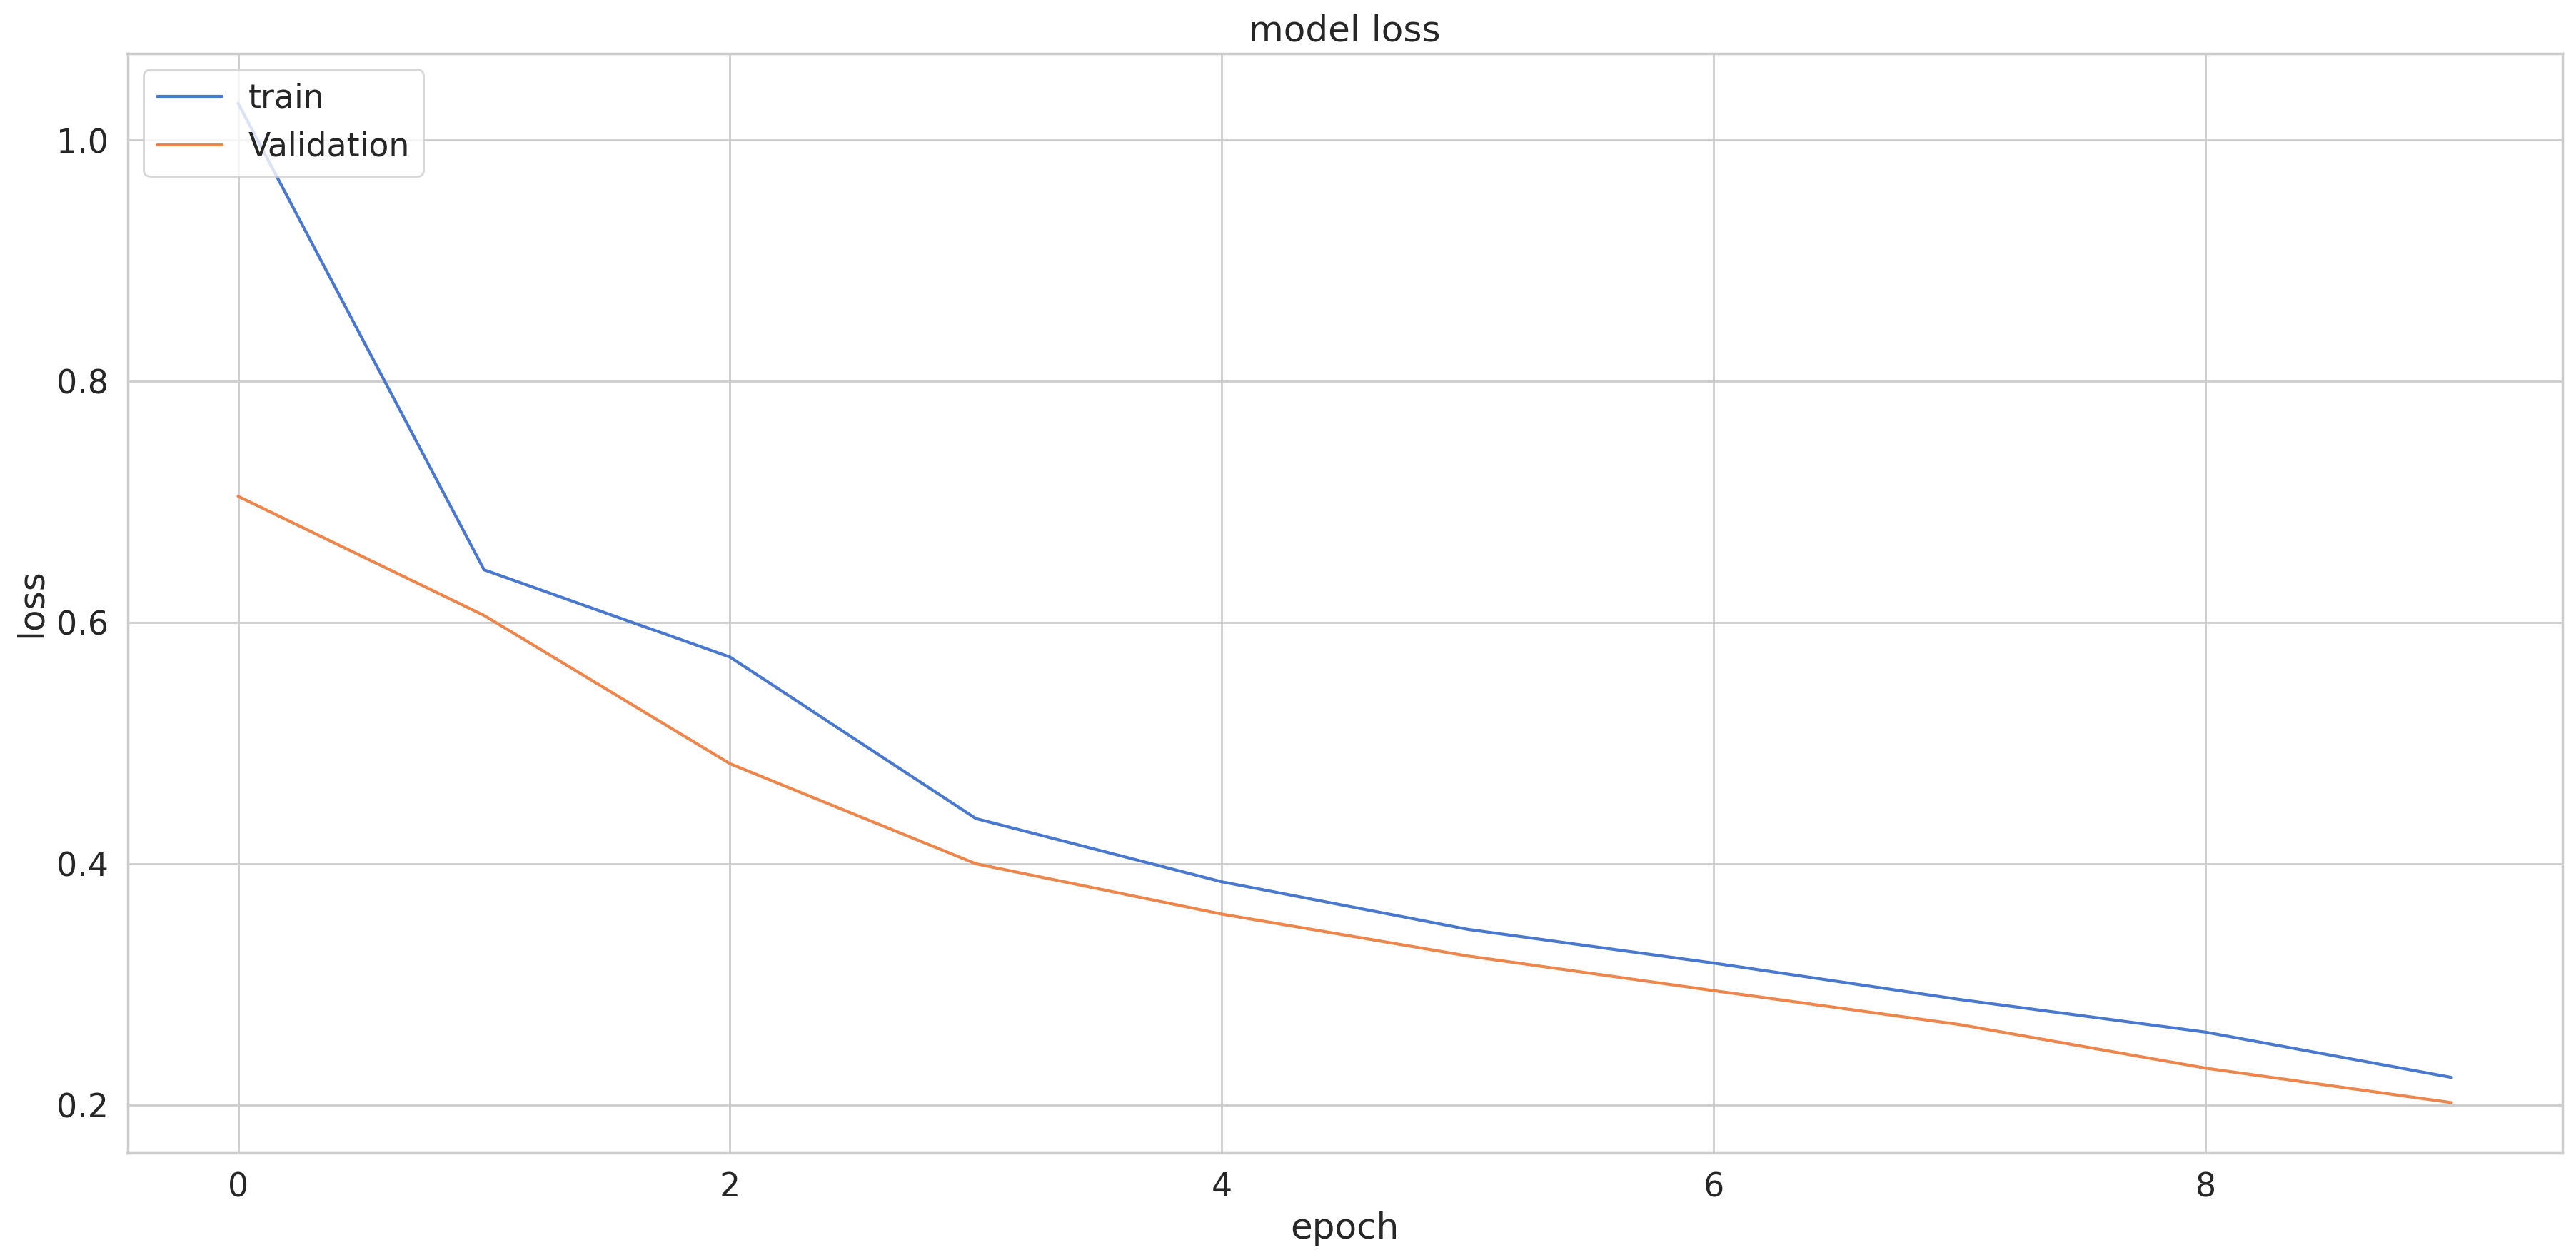

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

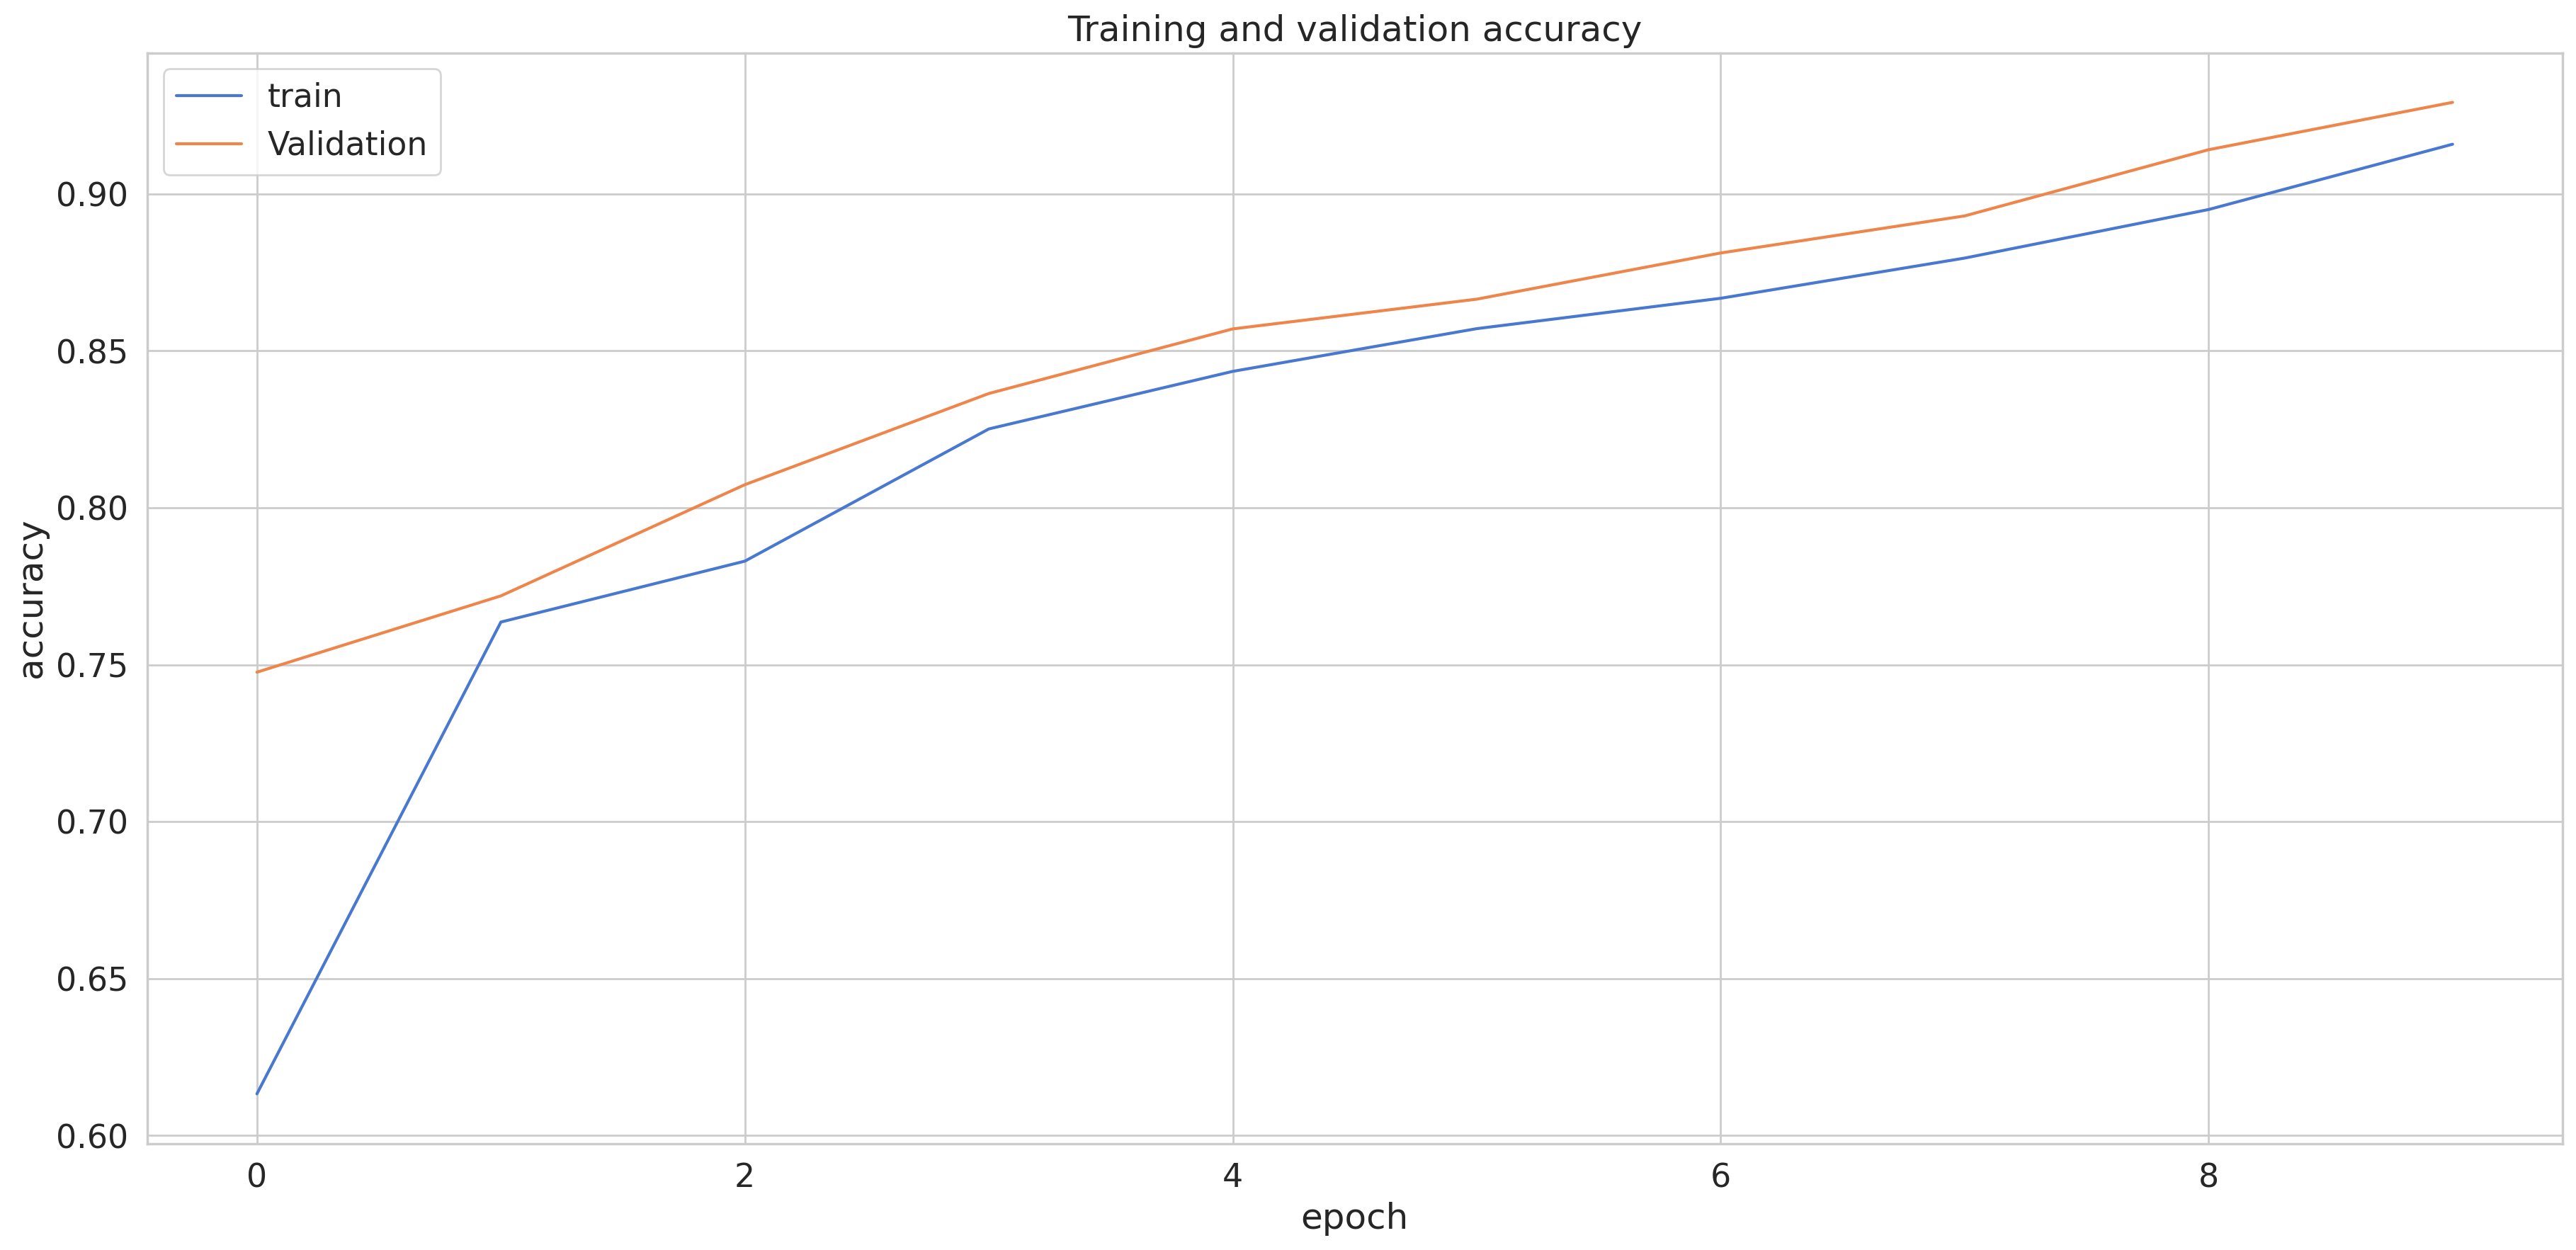

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 5s 8ms/step
f1_score =  0.9275867860442236
0.9286760620296004
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8490
           1       0.97      0.98      0.98      6843
           2       0.78      0.79      0.78      2459
           3       0.77      0.69      0.73      2005

    accuracy                           0.93     19797
   macro avg       0.87      0.86      0.87     19797
weighted avg       0.93      0.93      0.93     19797



<Axes: >

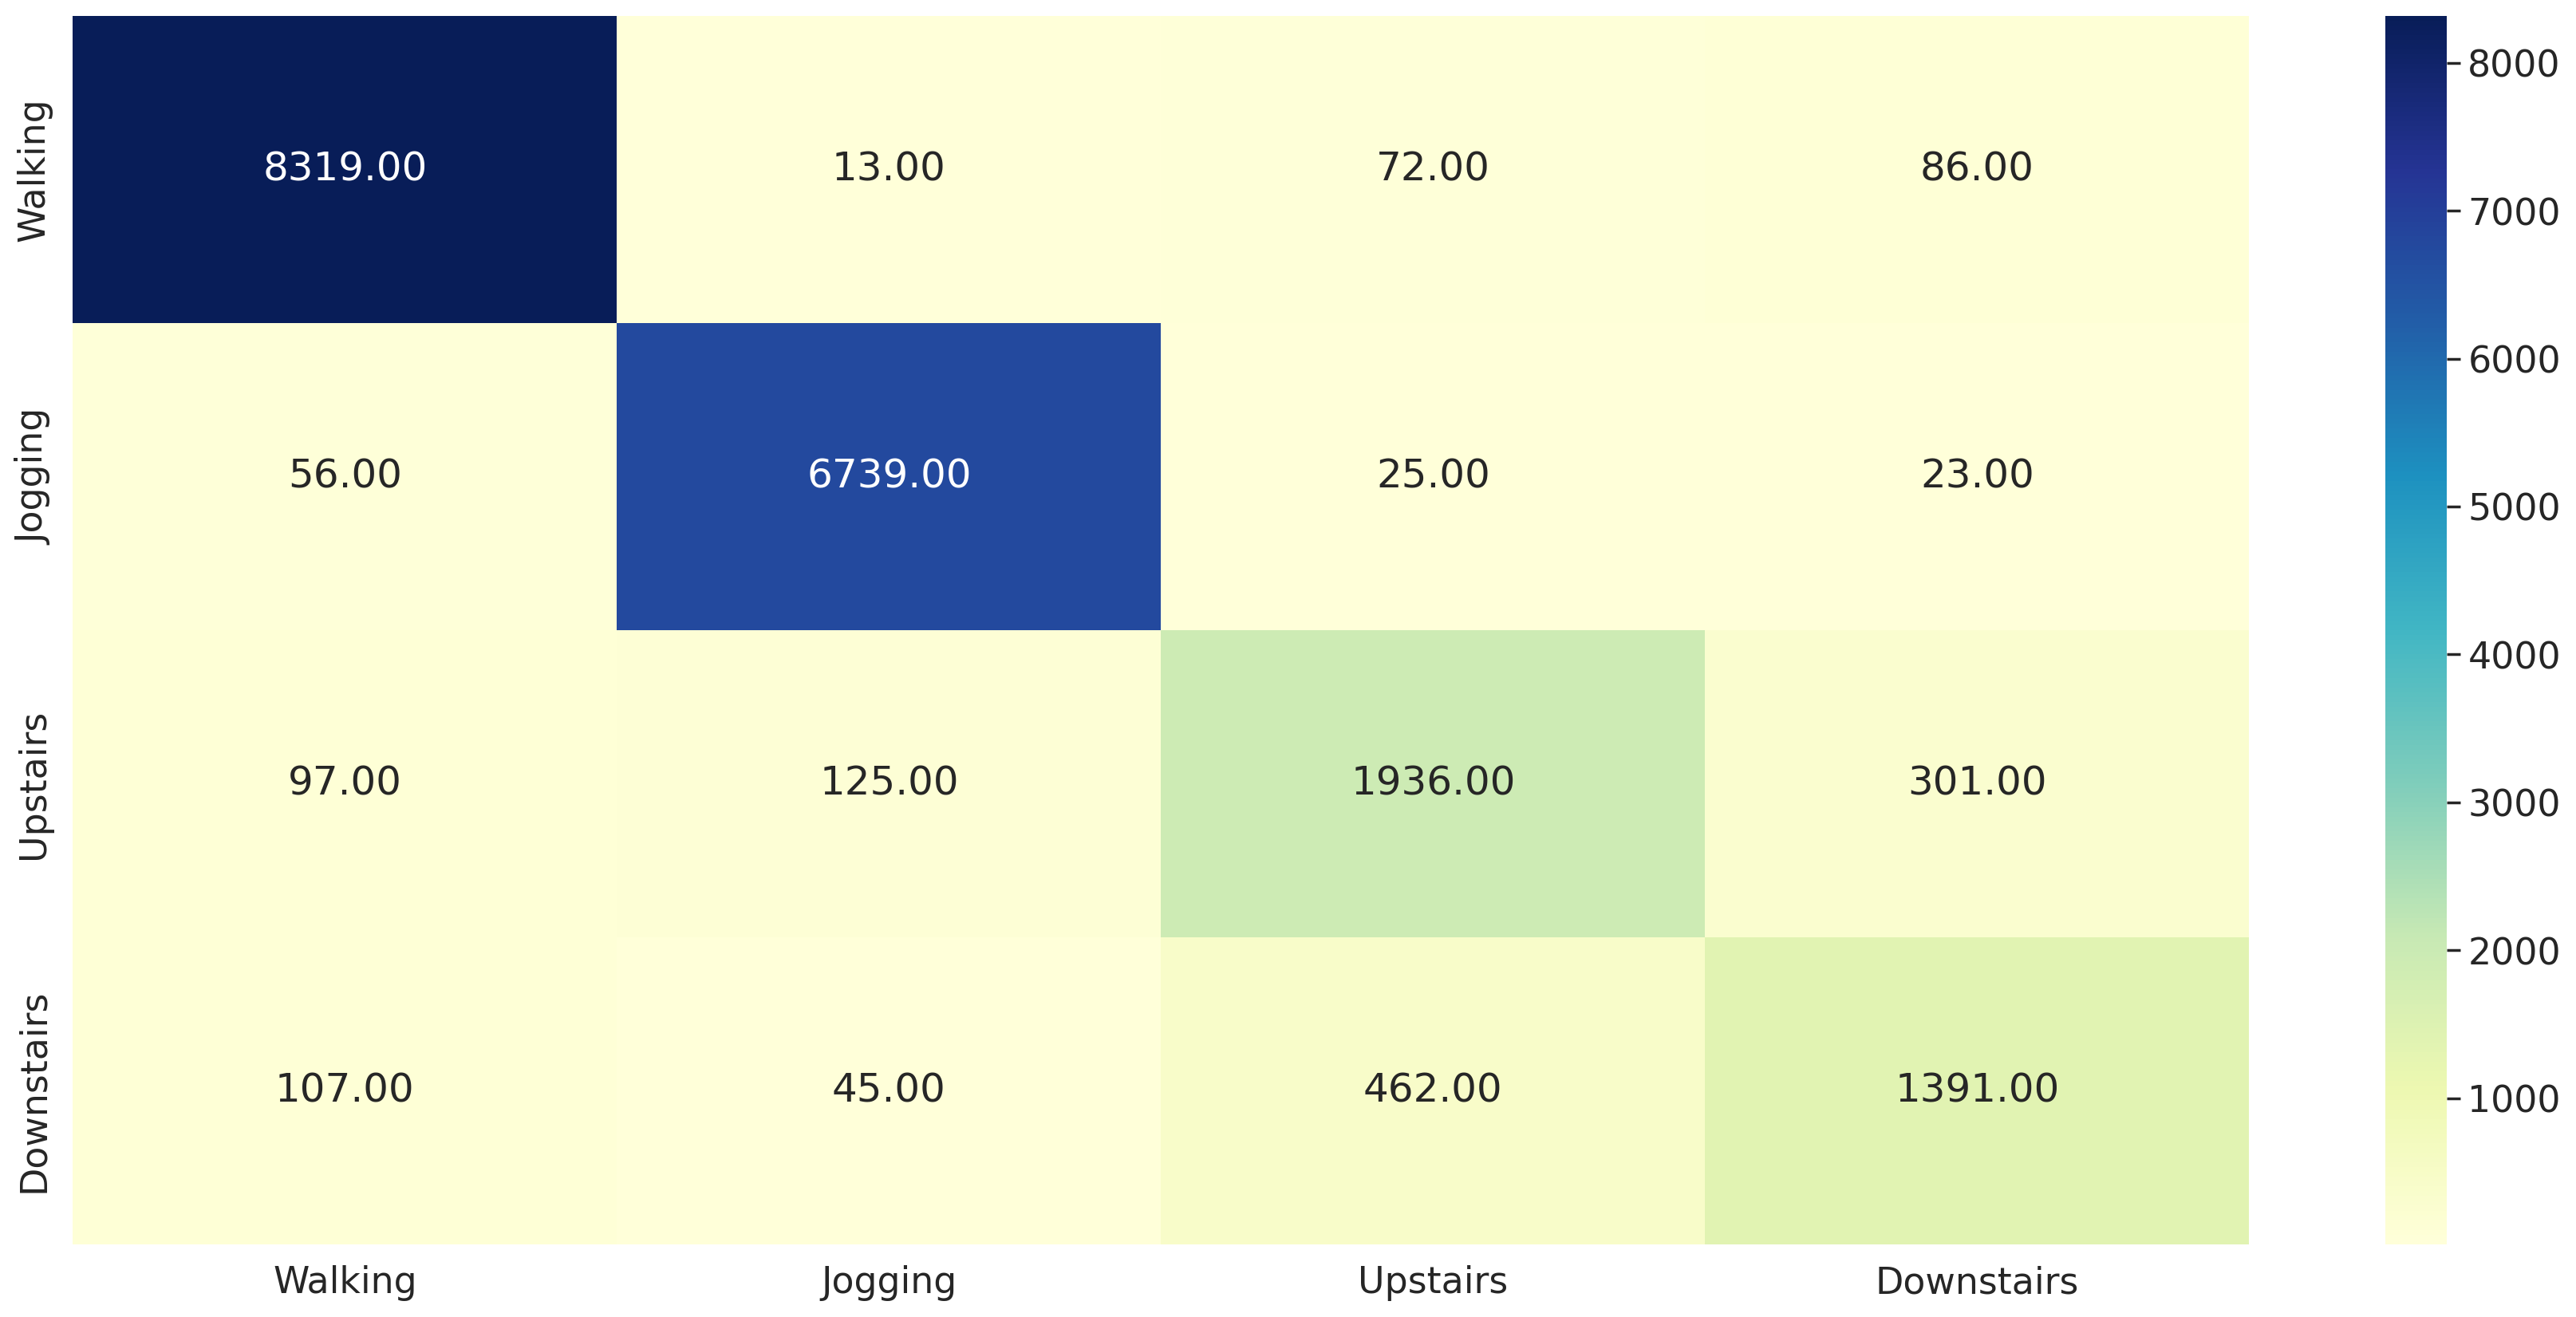

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [ ]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 158660 (619.77 KB)
Trainable params: 158

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 146s 286ms/step - loss: 0.5670 - accuracy: 0.7835 - val_loss: 0.3362 - val_accuracy: 0.8677
Epoch 2/10
495/495 [==============================] - 141s 285ms/step - loss: 0.2479 - accuracy: 0.9133 - val_loss: 0.1774 - val_accuracy: 0.9396
Epoch 3/10
495/495 [==============================] - 147s 297ms/step - loss: 0.1625 - accuracy: 0.9456 - val_loss: 0.1289 - val_accuracy: 0.9585
Epoch 4/10
495/495 [==============================] - 141s 286ms/step - loss: 0.1216 - accuracy: 0.9590 - val_loss: 0.1118 - val_accuracy: 0.9619
Epoch 5/10
495/495 [==============================] - 132s 266ms/step - loss: 0.0945 - accuracy: 0.9680 - val_loss: 0.0778 - val_accuracy: 0.9744
Epoch 6/10
495/495 [==============================] - 140s 282ms/step - loss: 0.0778 - accuracy: 0.9750 - val_loss: 0.0733 - val_accuracy: 0.9771
Epoch 7/10
495/495 [==============================] - 133s 268ms/step - loss: 0.0646 - accuracy: 0.9786 - val_loss: 0.0592 -

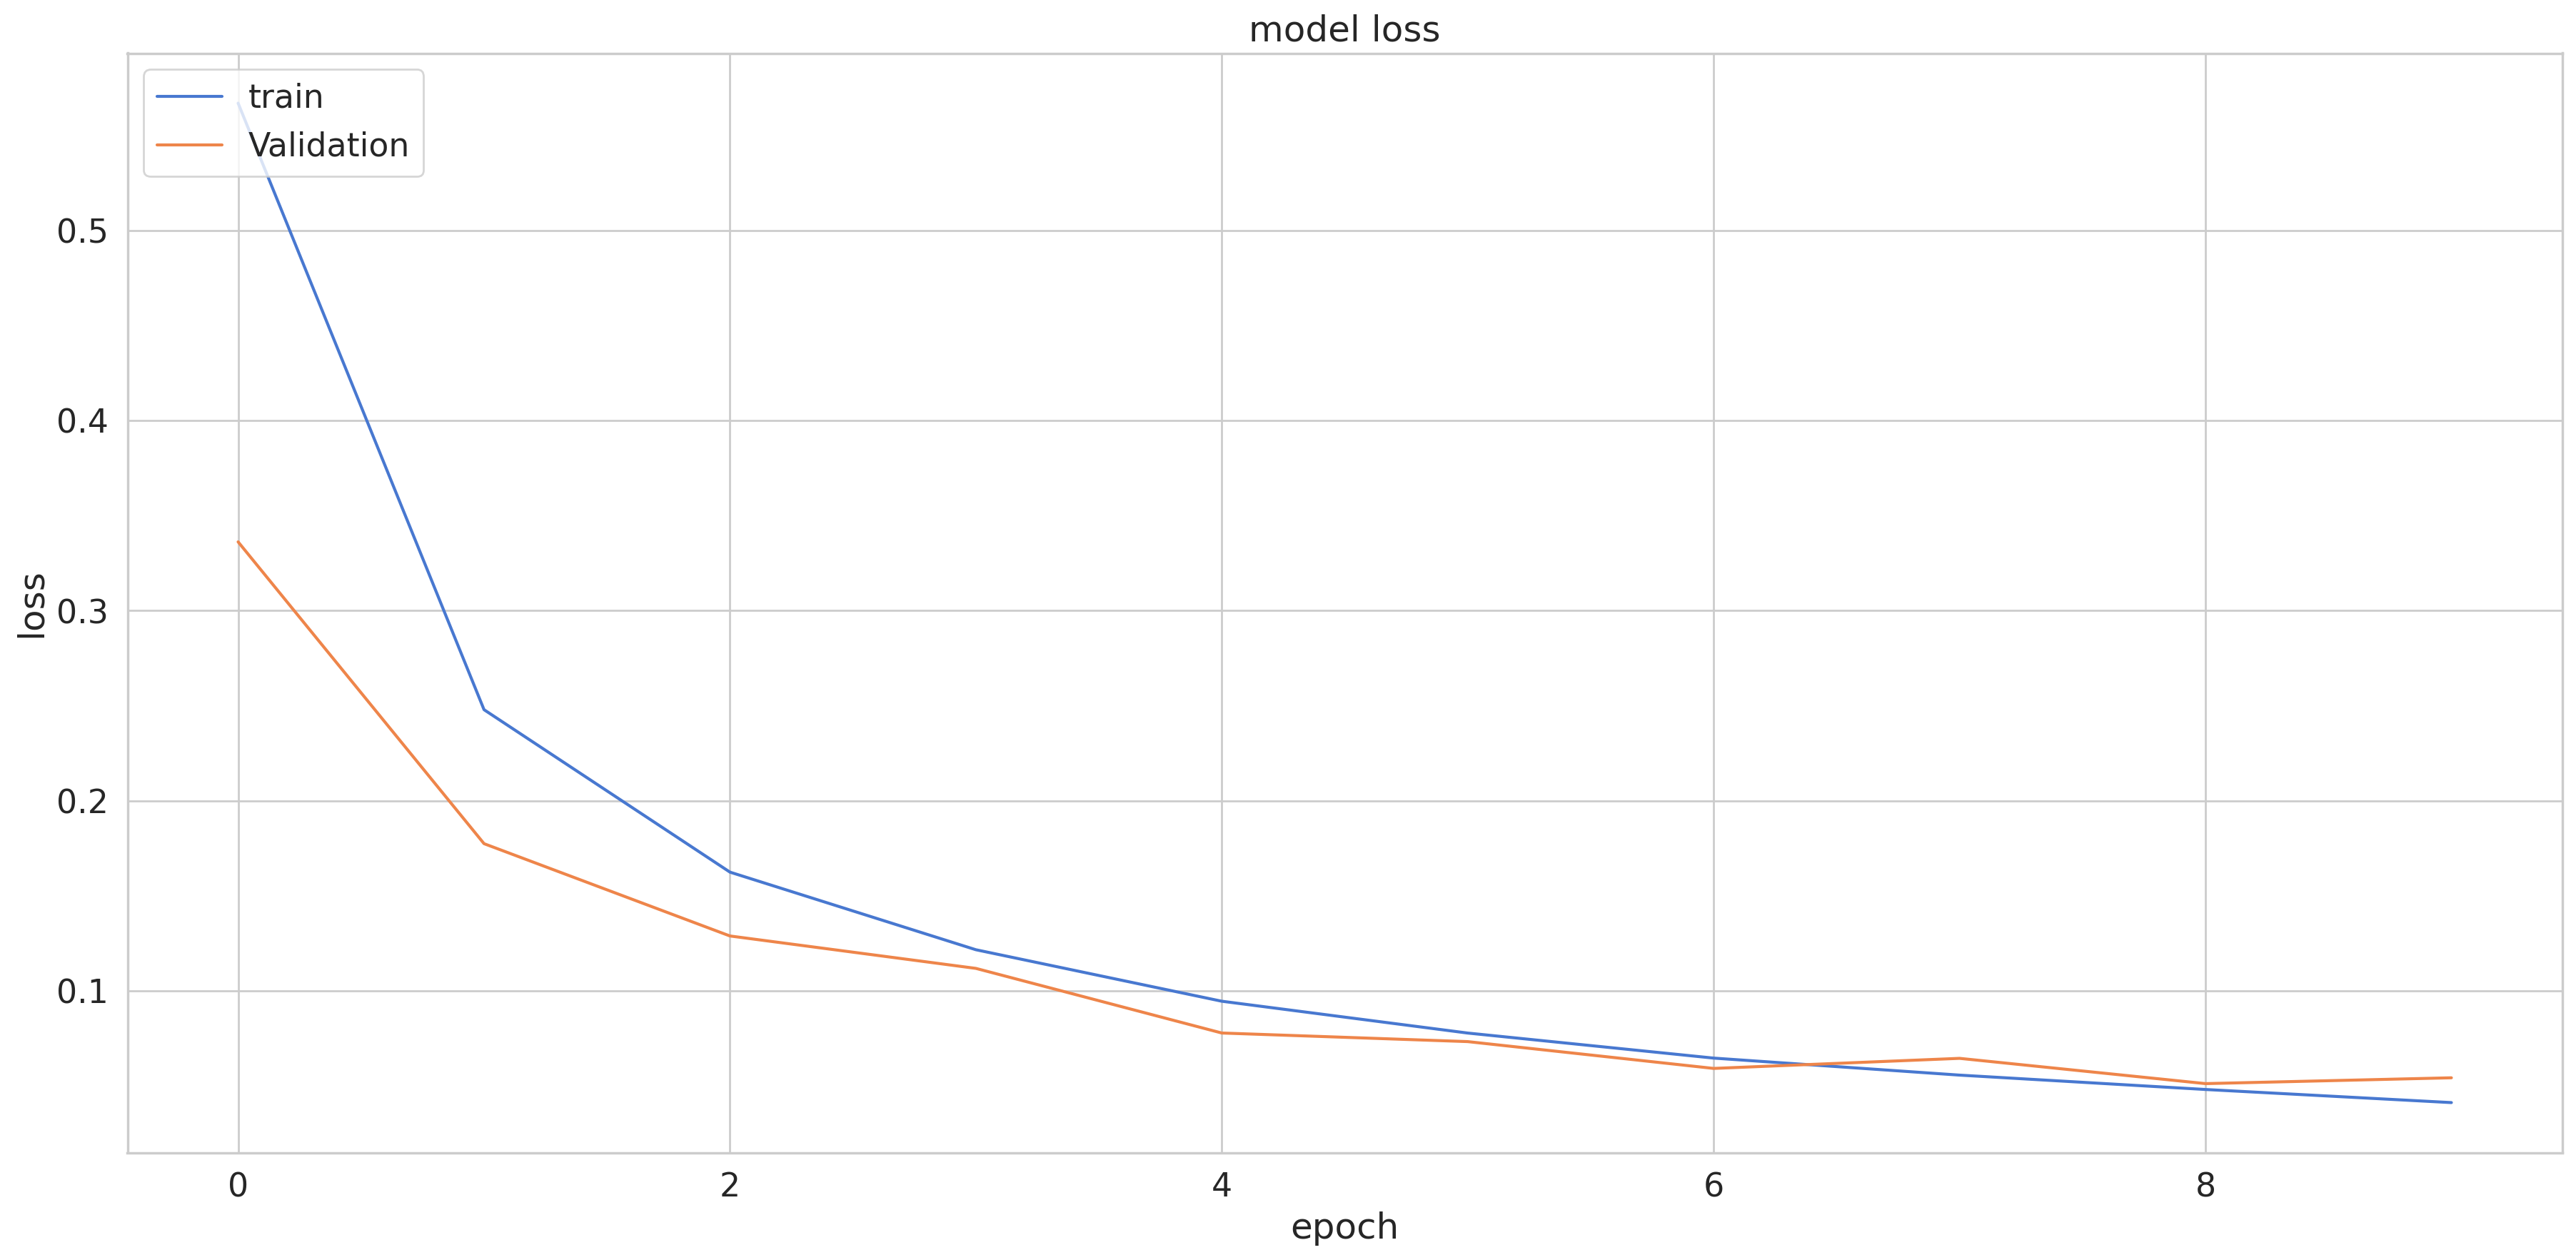

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

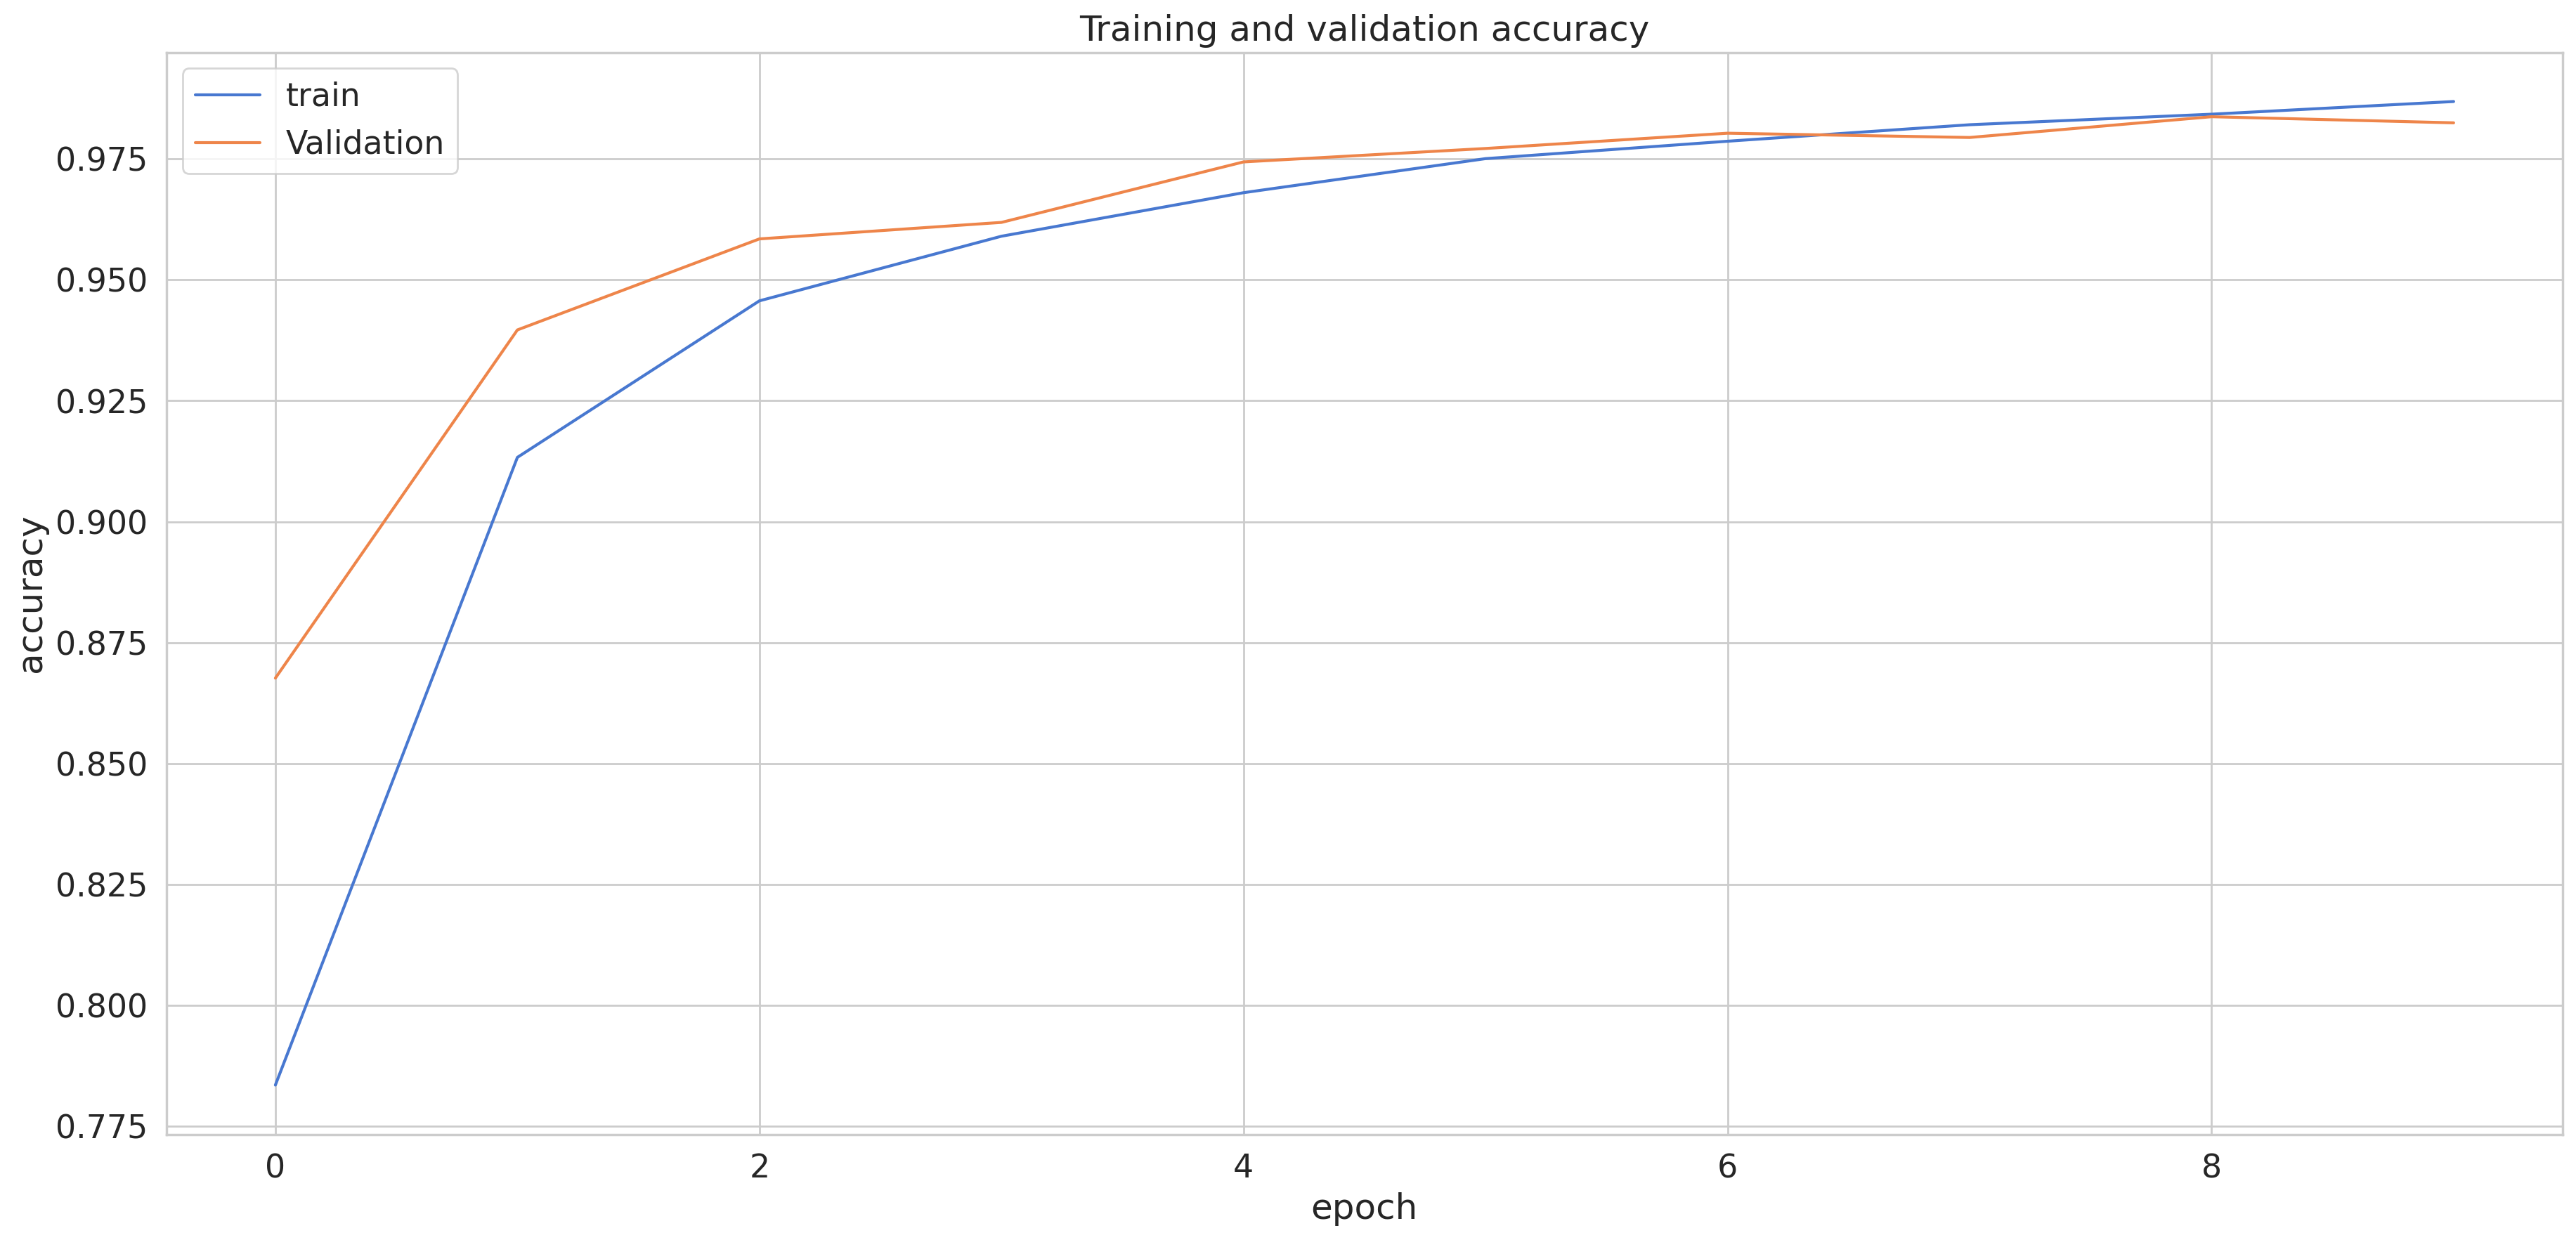

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 18s 27ms/step
f1_score =  0.9813265378884628
0.9811587614284992
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.94      0.96      0.95      2459
           3       0.92      0.96      0.94      2005

    accuracy                           0.98     19797
   macro avg       0.96      0.97      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

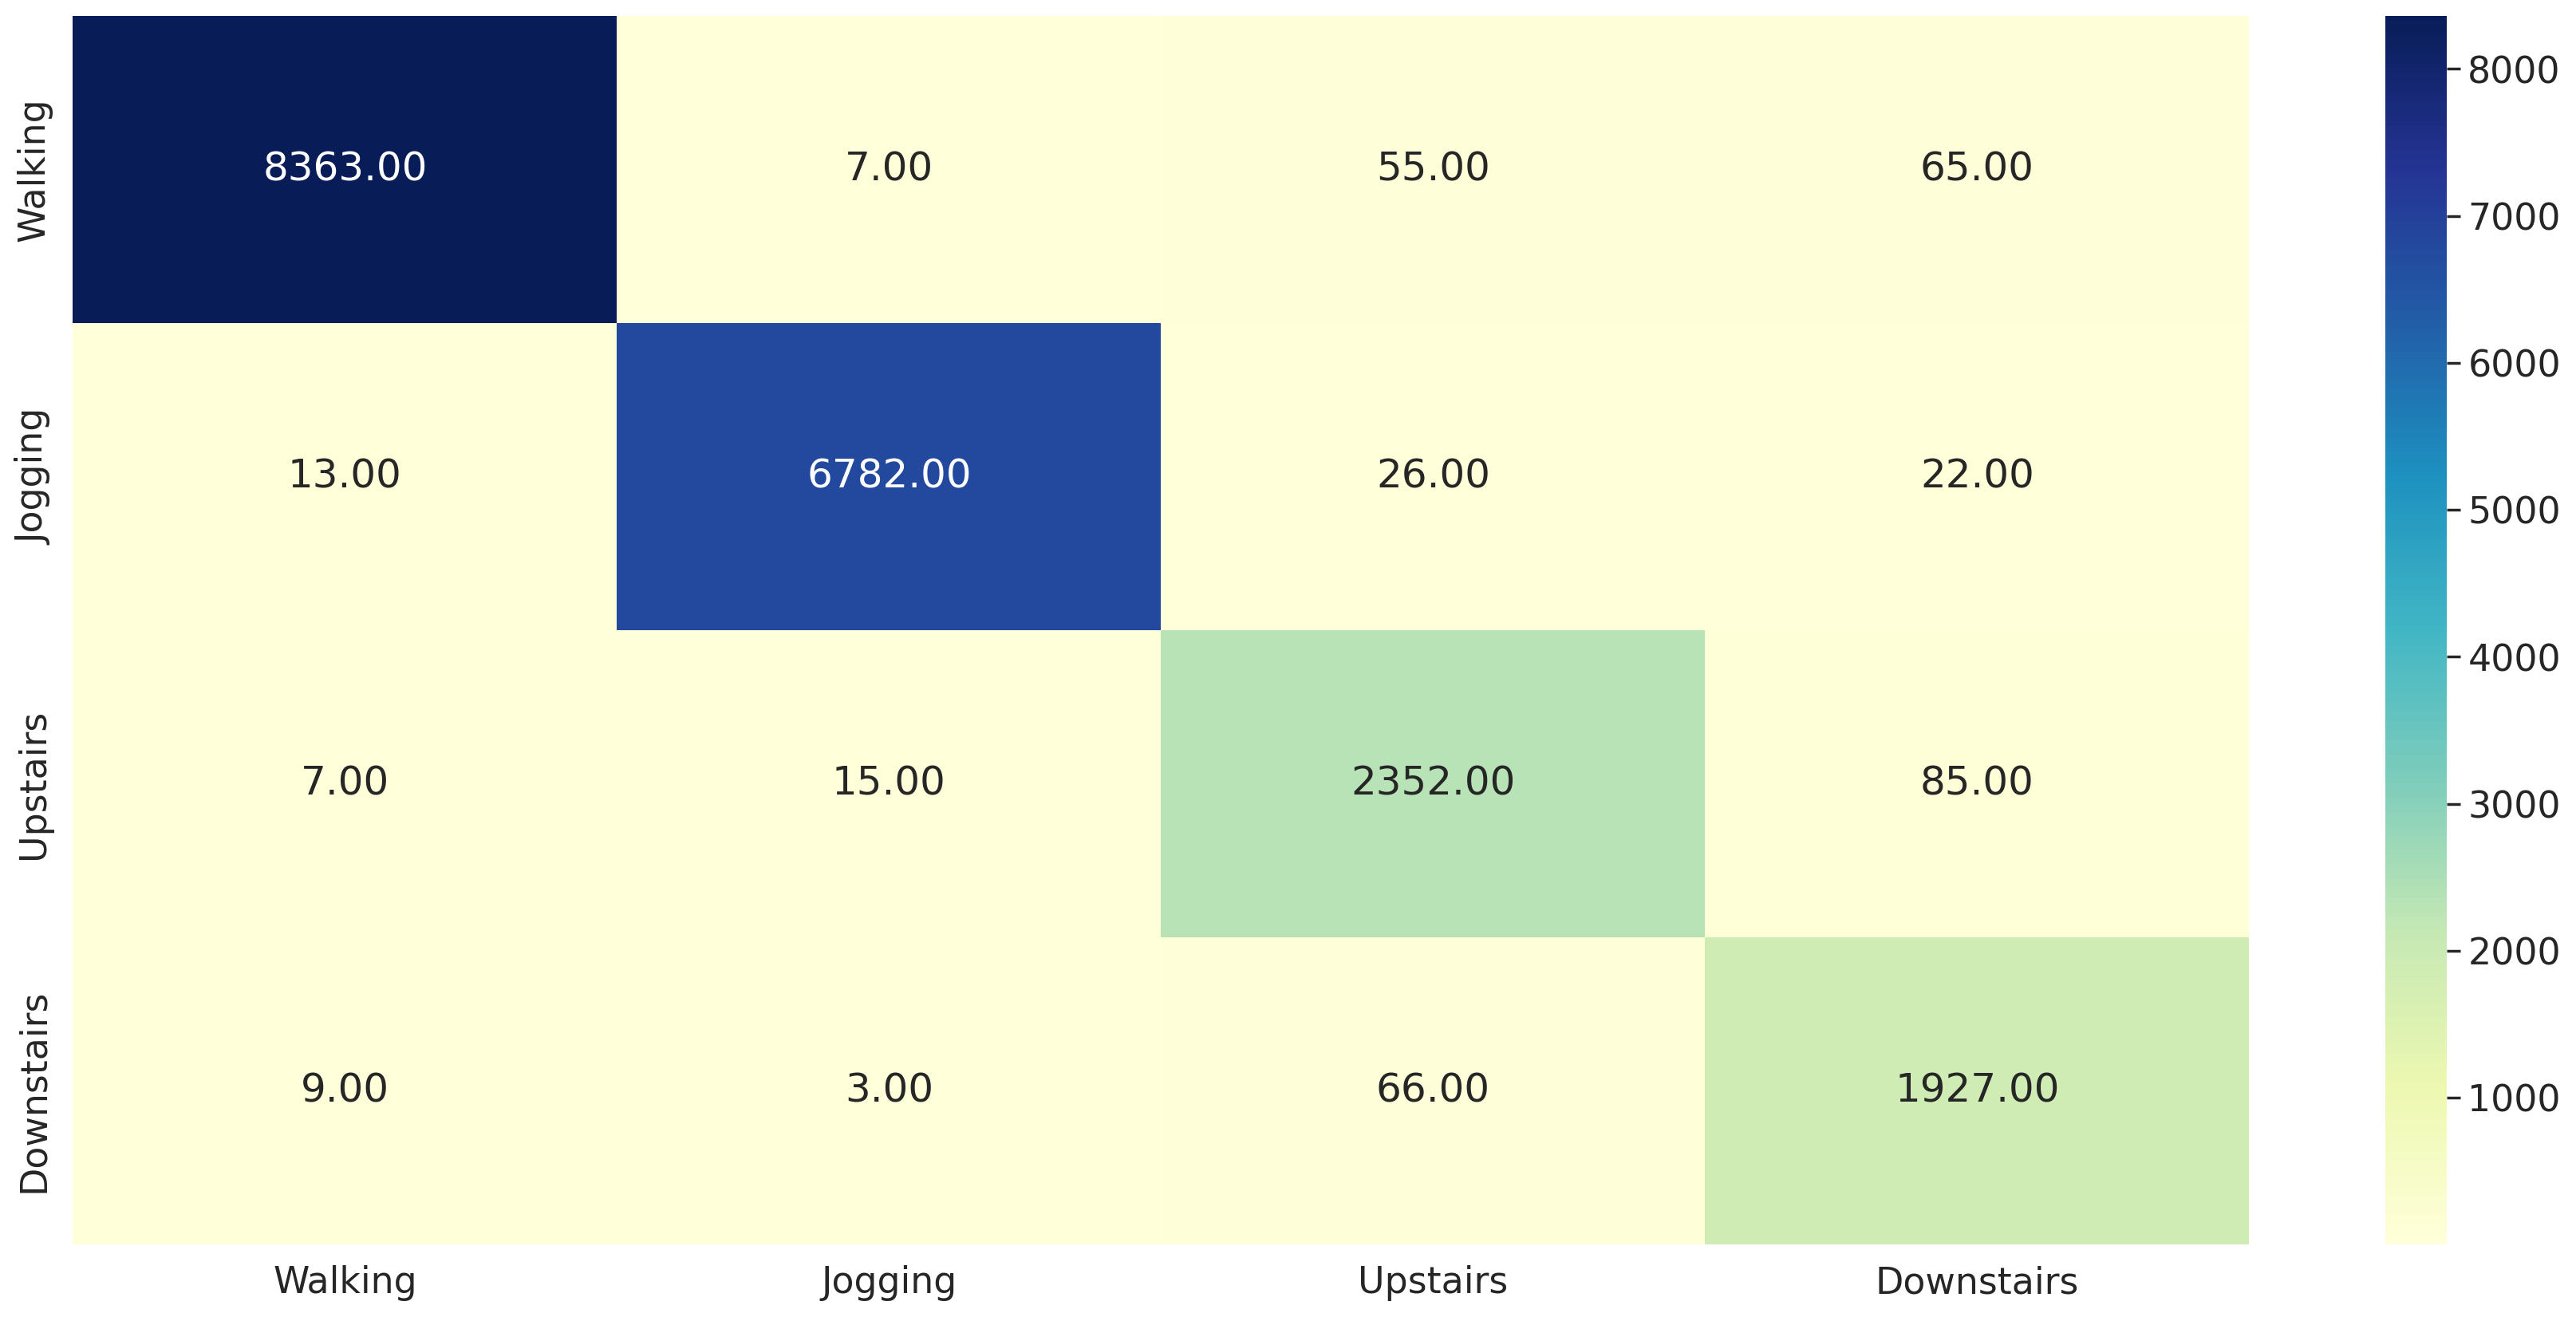

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [ ]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 211s 414ms/step - loss: 0.5732 - accuracy: 0.7849 - val_loss: 0.3234 - val_accuracy: 0.8777
Epoch 2/10
495/495 [==============================] - 204s 412ms/step - loss: 0.2445 - accuracy: 0.9150 - val_loss: 0.1790 - val_accuracy: 0.9398
Epoch 3/10
495/495 [==============================] - 211s 427ms/step - loss: 0.1536 - accuracy: 0.9491 - val_loss: 0.1167 - val_accuracy: 0.9629
Epoch 4/10
495/495 [==============================] - 208s 421ms/step - loss: 0.1086 - accuracy: 0.9637 - val_loss: 0.0869 - val_accuracy: 0.9723
Epoch 5/10
495/495 [==============================] - 213s 430ms/step - loss: 0.0844 - accuracy: 0.9728 - val_loss: 0.0667 - val_accuracy: 0.9783
Epoch 6/10
495/495 [==============================] - 209s 422ms/step - loss: 0.0706 - accuracy: 0.9775 - val_loss: 0.0522 - val_accuracy: 0.9834
Epoch 7/10
495/495 [==============================] - 210s 423ms/step - loss: 0.0660 - accuracy: 0.9794 - val_loss: 0.0497 -

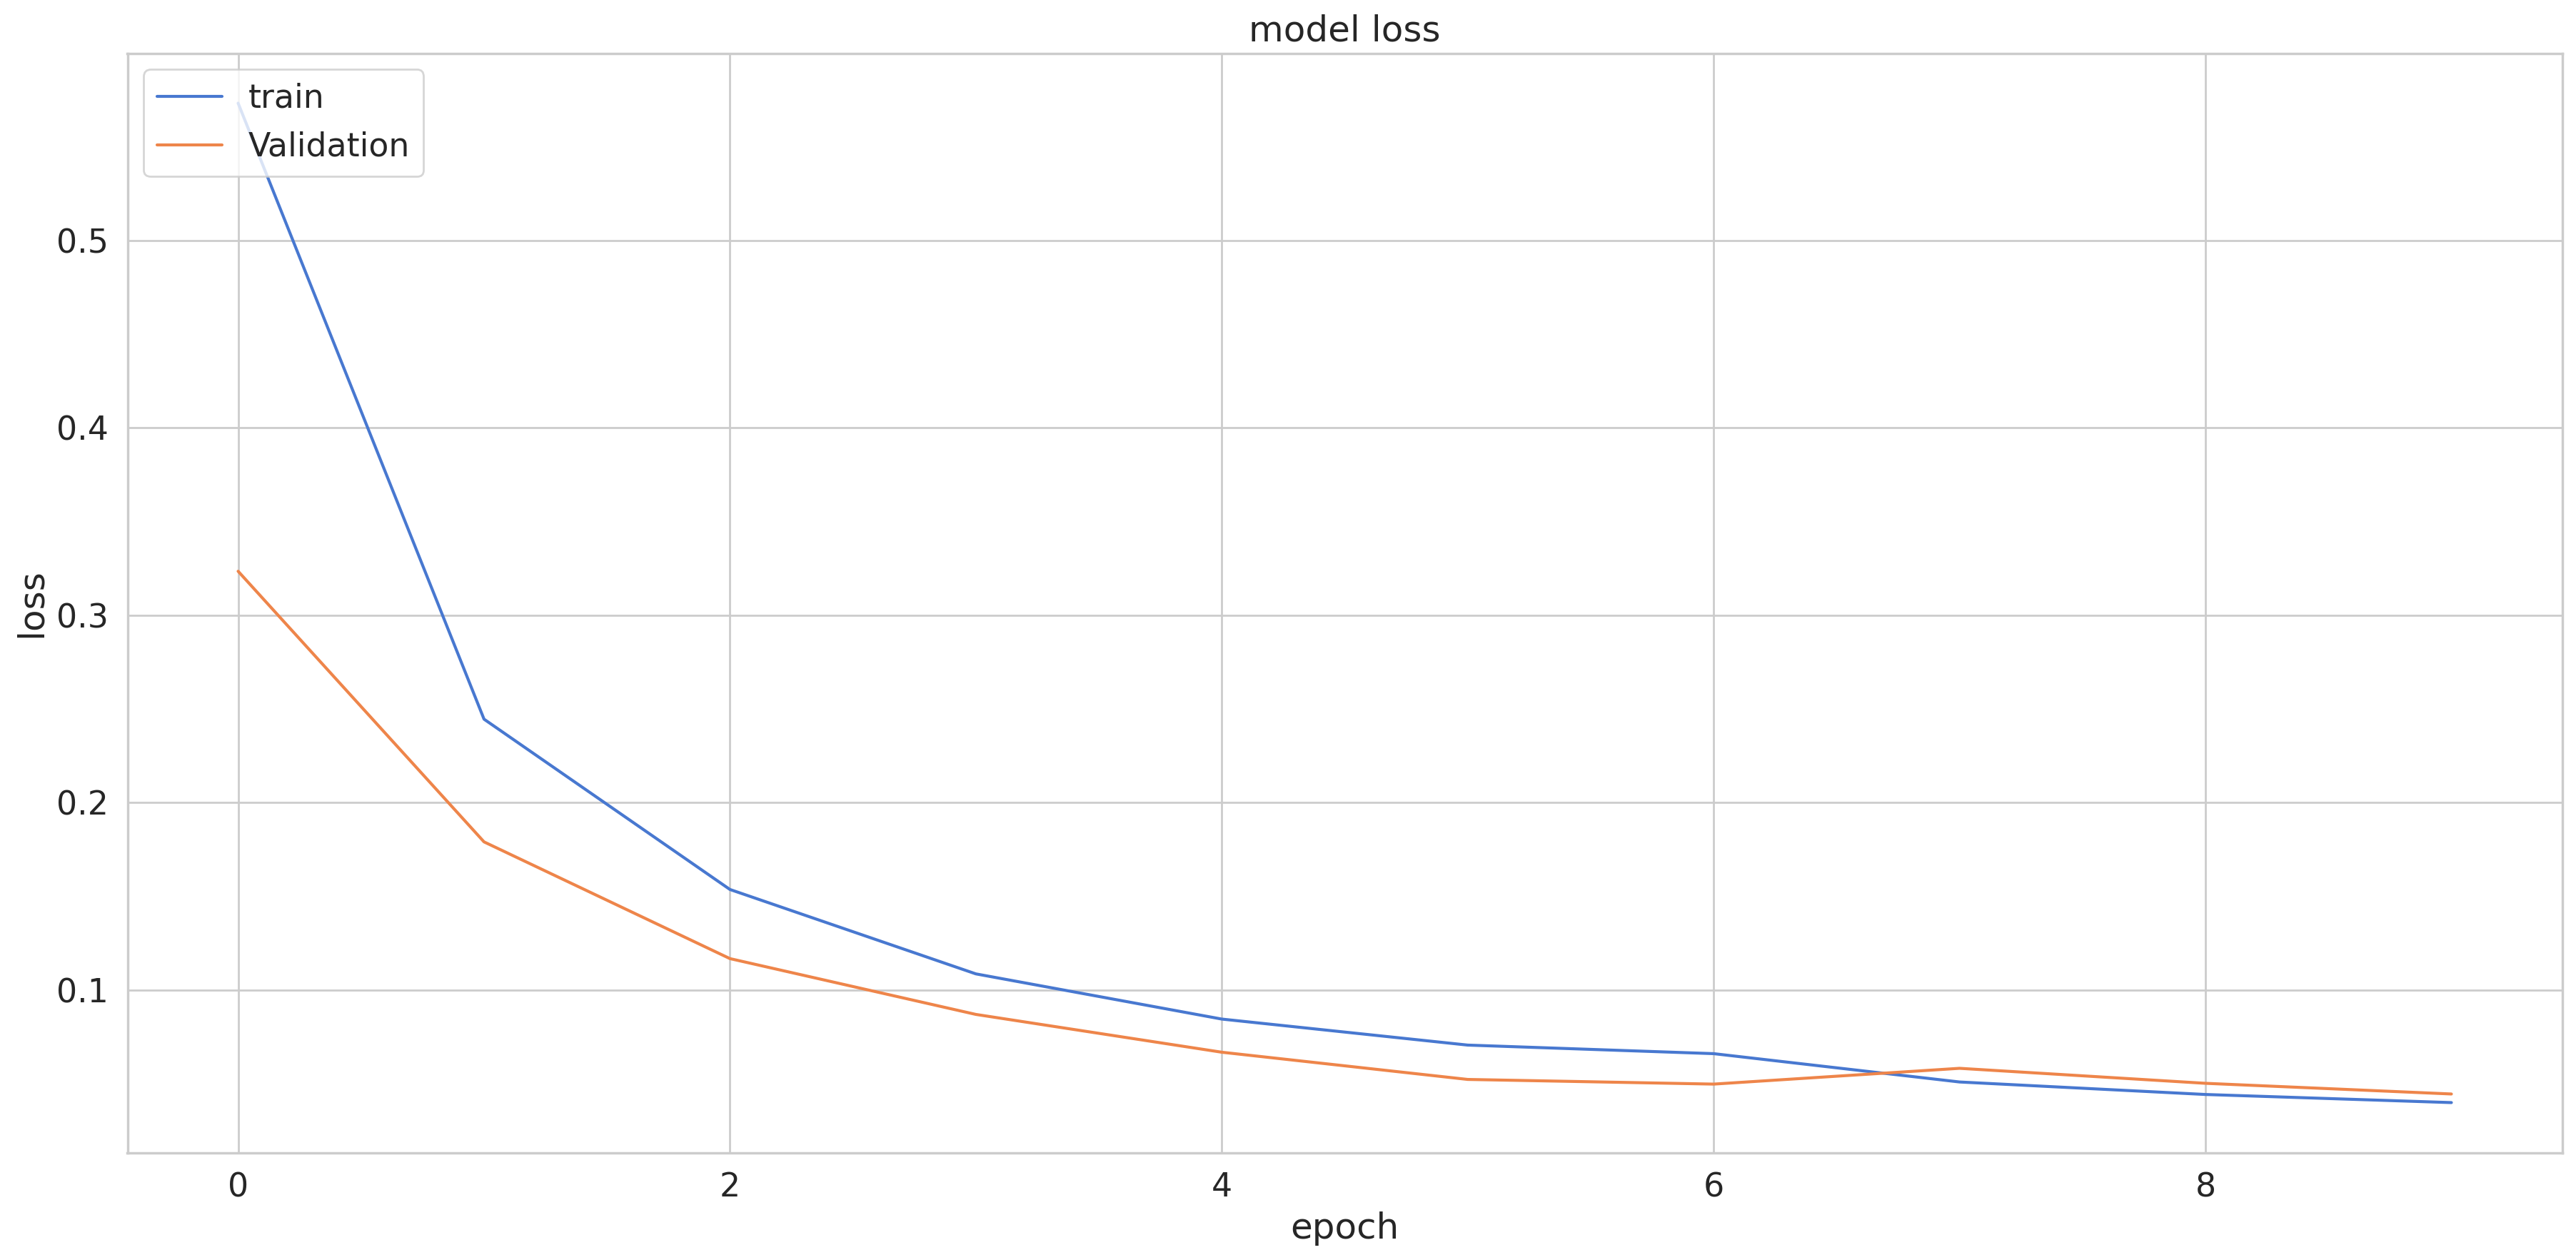

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

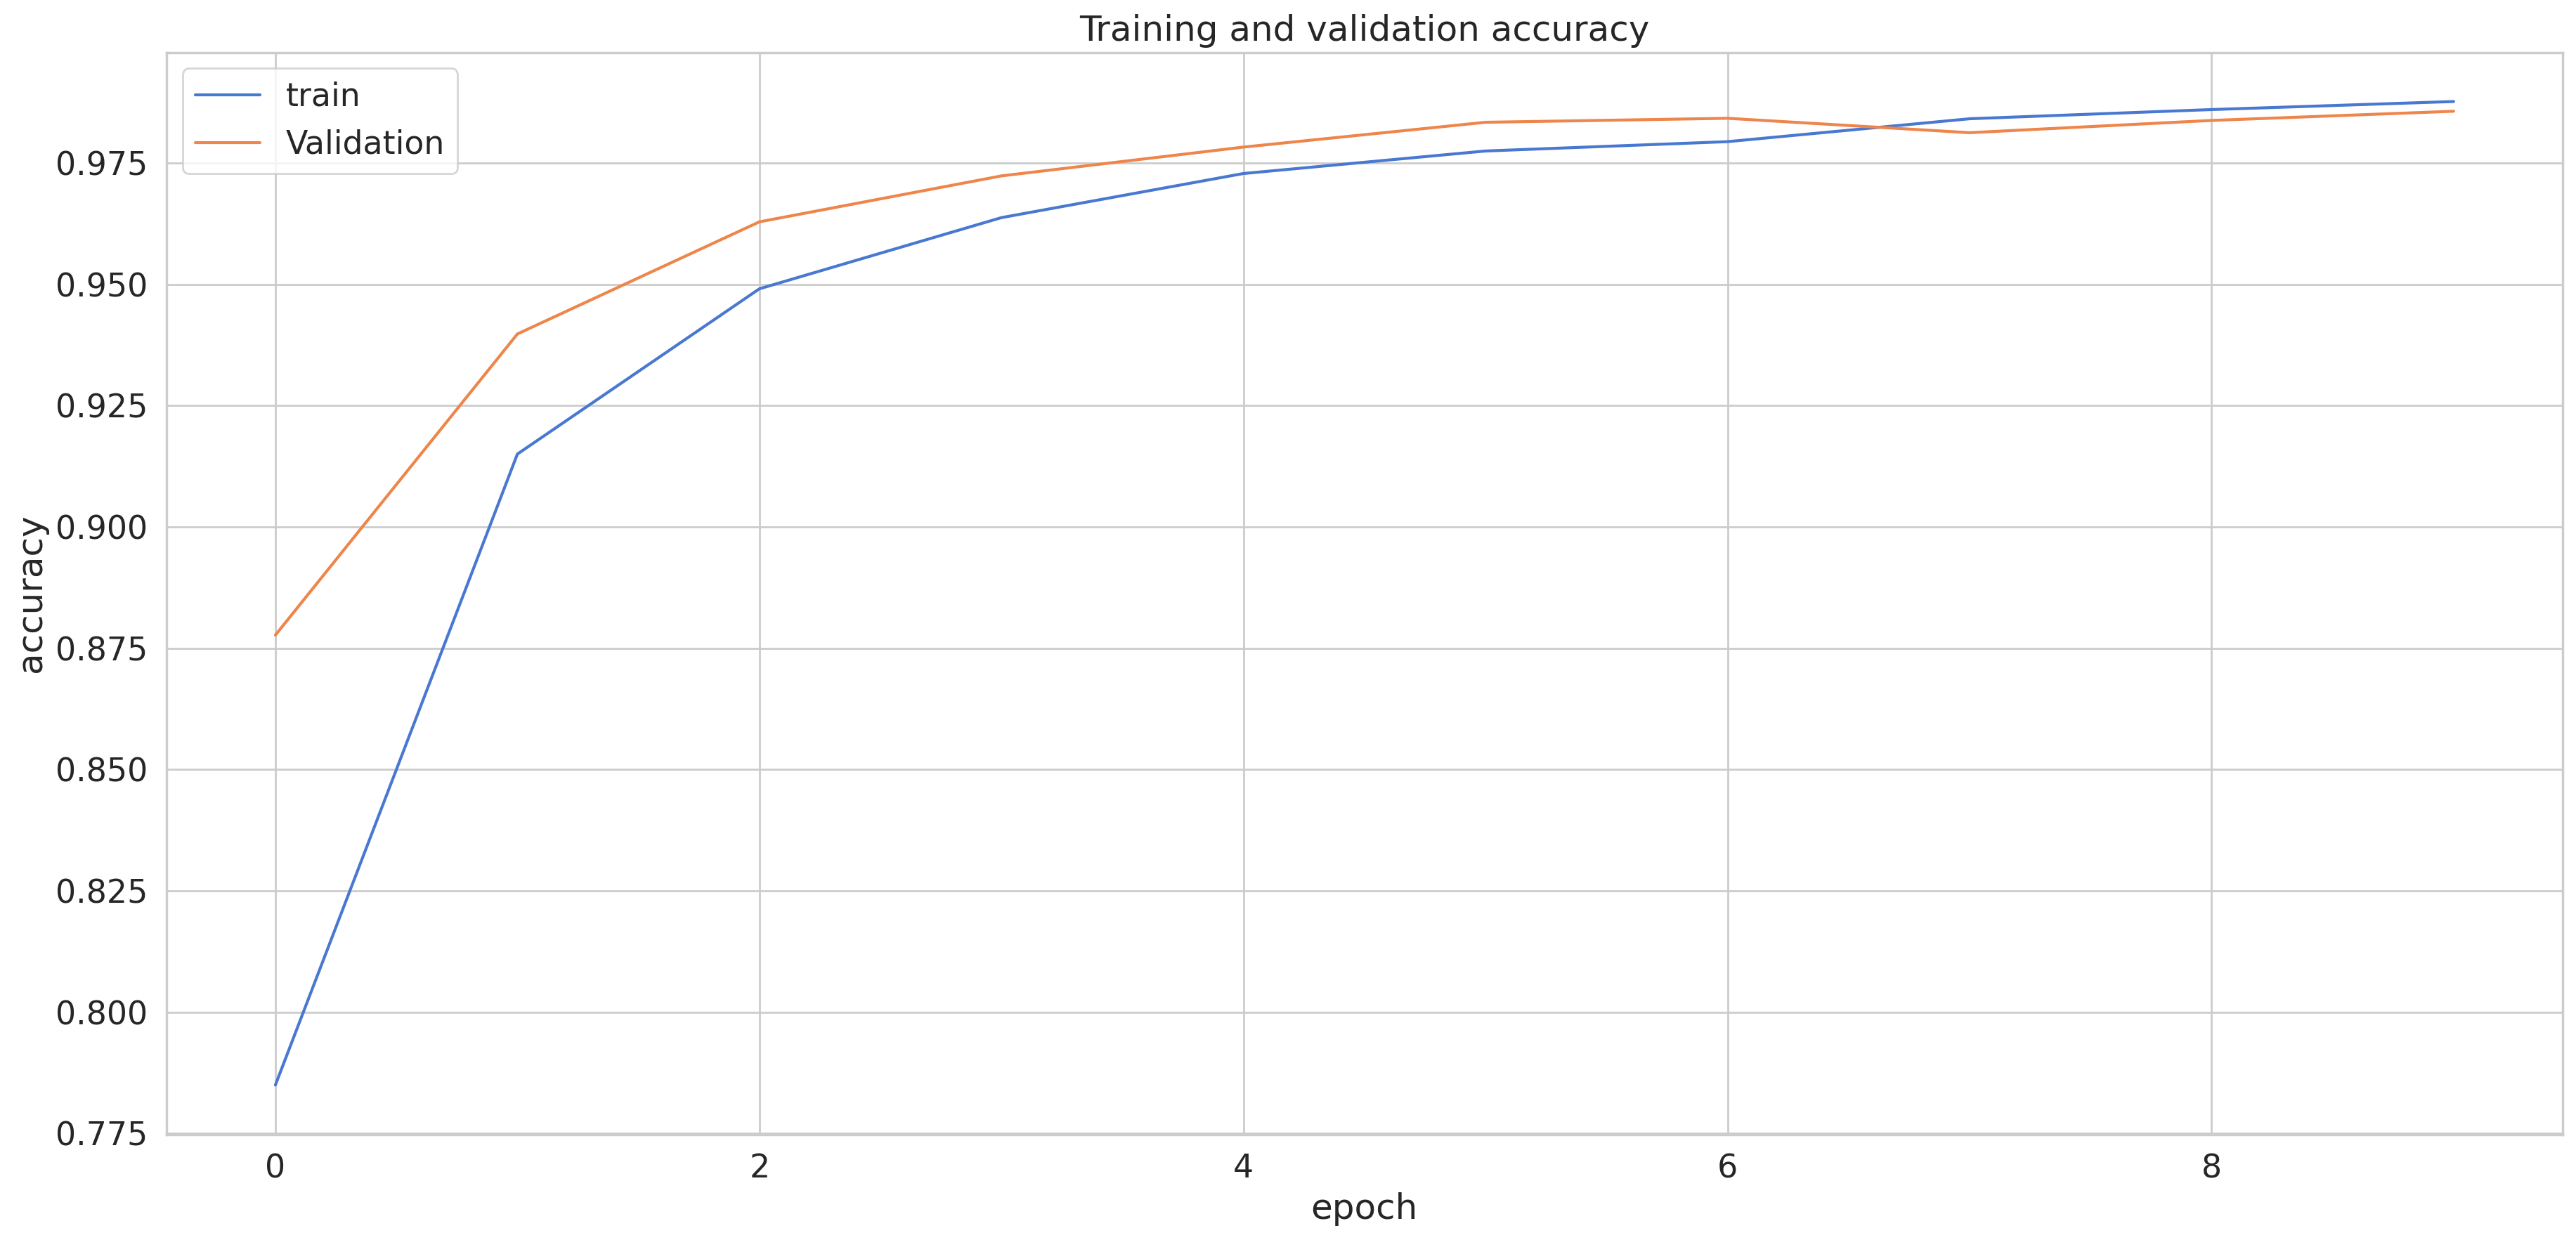

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 27s 42ms/step
f1_score =  0.9827931128296696
0.9826741425468505
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.95      0.95      0.95      2459
           3       0.92      0.97      0.95      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.97      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

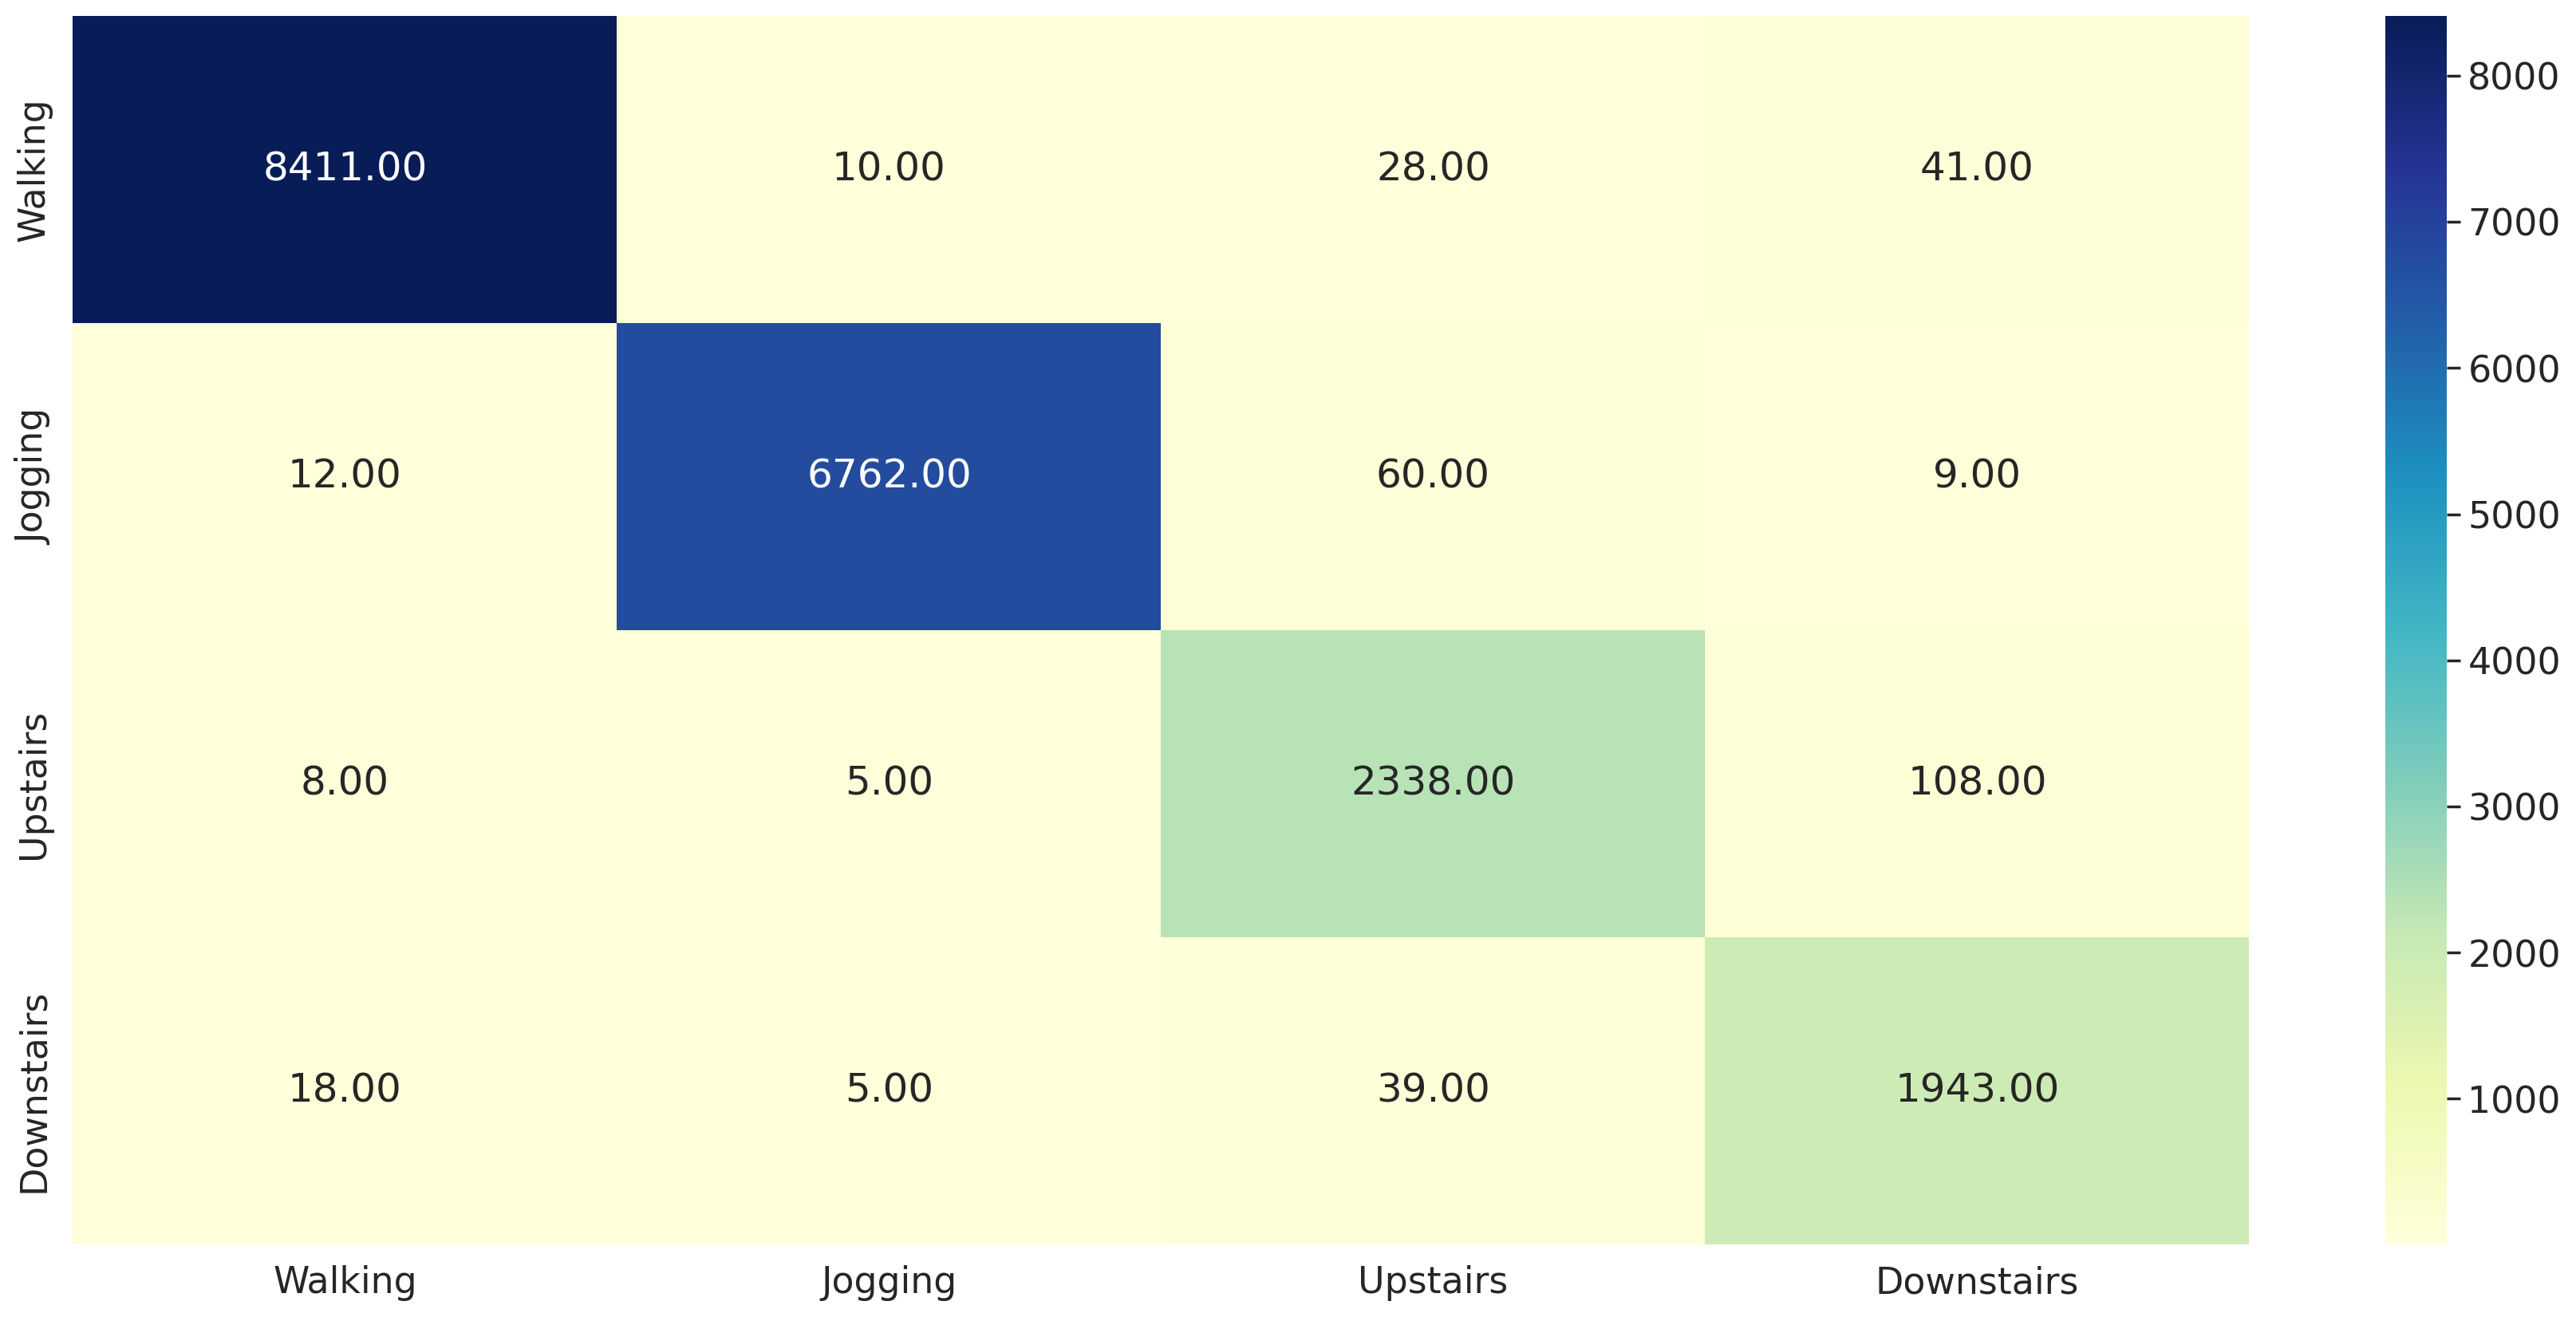

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [ ]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_6 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_7 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_8 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_9 (GRU)                 (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 312s 610ms/step - loss: 0.5603 - accuracy: 0.7925 - val_loss: 0.3233 - val_accuracy: 0.8757
Epoch 2/10
495/495 [==============================] - 307s 619ms/step - loss: 0.2426 - accuracy: 0.9162 - val_loss: 0.1733 - val_accuracy: 0.9430
Epoch 3/10
495/495 [==============================] - 301s 607ms/step - loss: 0.1469 - accuracy: 0.9521 - val_loss: 0.1009 - val_accuracy: 0.9674
Epoch 4/10
495/495 [==============================] - 302s 610ms/step - loss: 0.0994 - accuracy: 0.9667 - val_loss: 0.0845 - val_accuracy: 0.9720
Epoch 5/10
495/495 [==============================] - 304s 614ms/step - loss: 0.0765 - accuracy: 0.9757 - val_loss: 0.0707 - val_accuracy: 0.9777
Epoch 6/10
495/495 [==============================] - 299s 604ms/step - loss: 0.0644 - accuracy: 0.9791 - val_loss: 0.0580 - val_accuracy: 0.9827
Epoch 7/10
495/495 [==============================] - 303s 613ms/step - loss: 0.0552 - accuracy: 0.9825 - val_loss: 0.0483 -

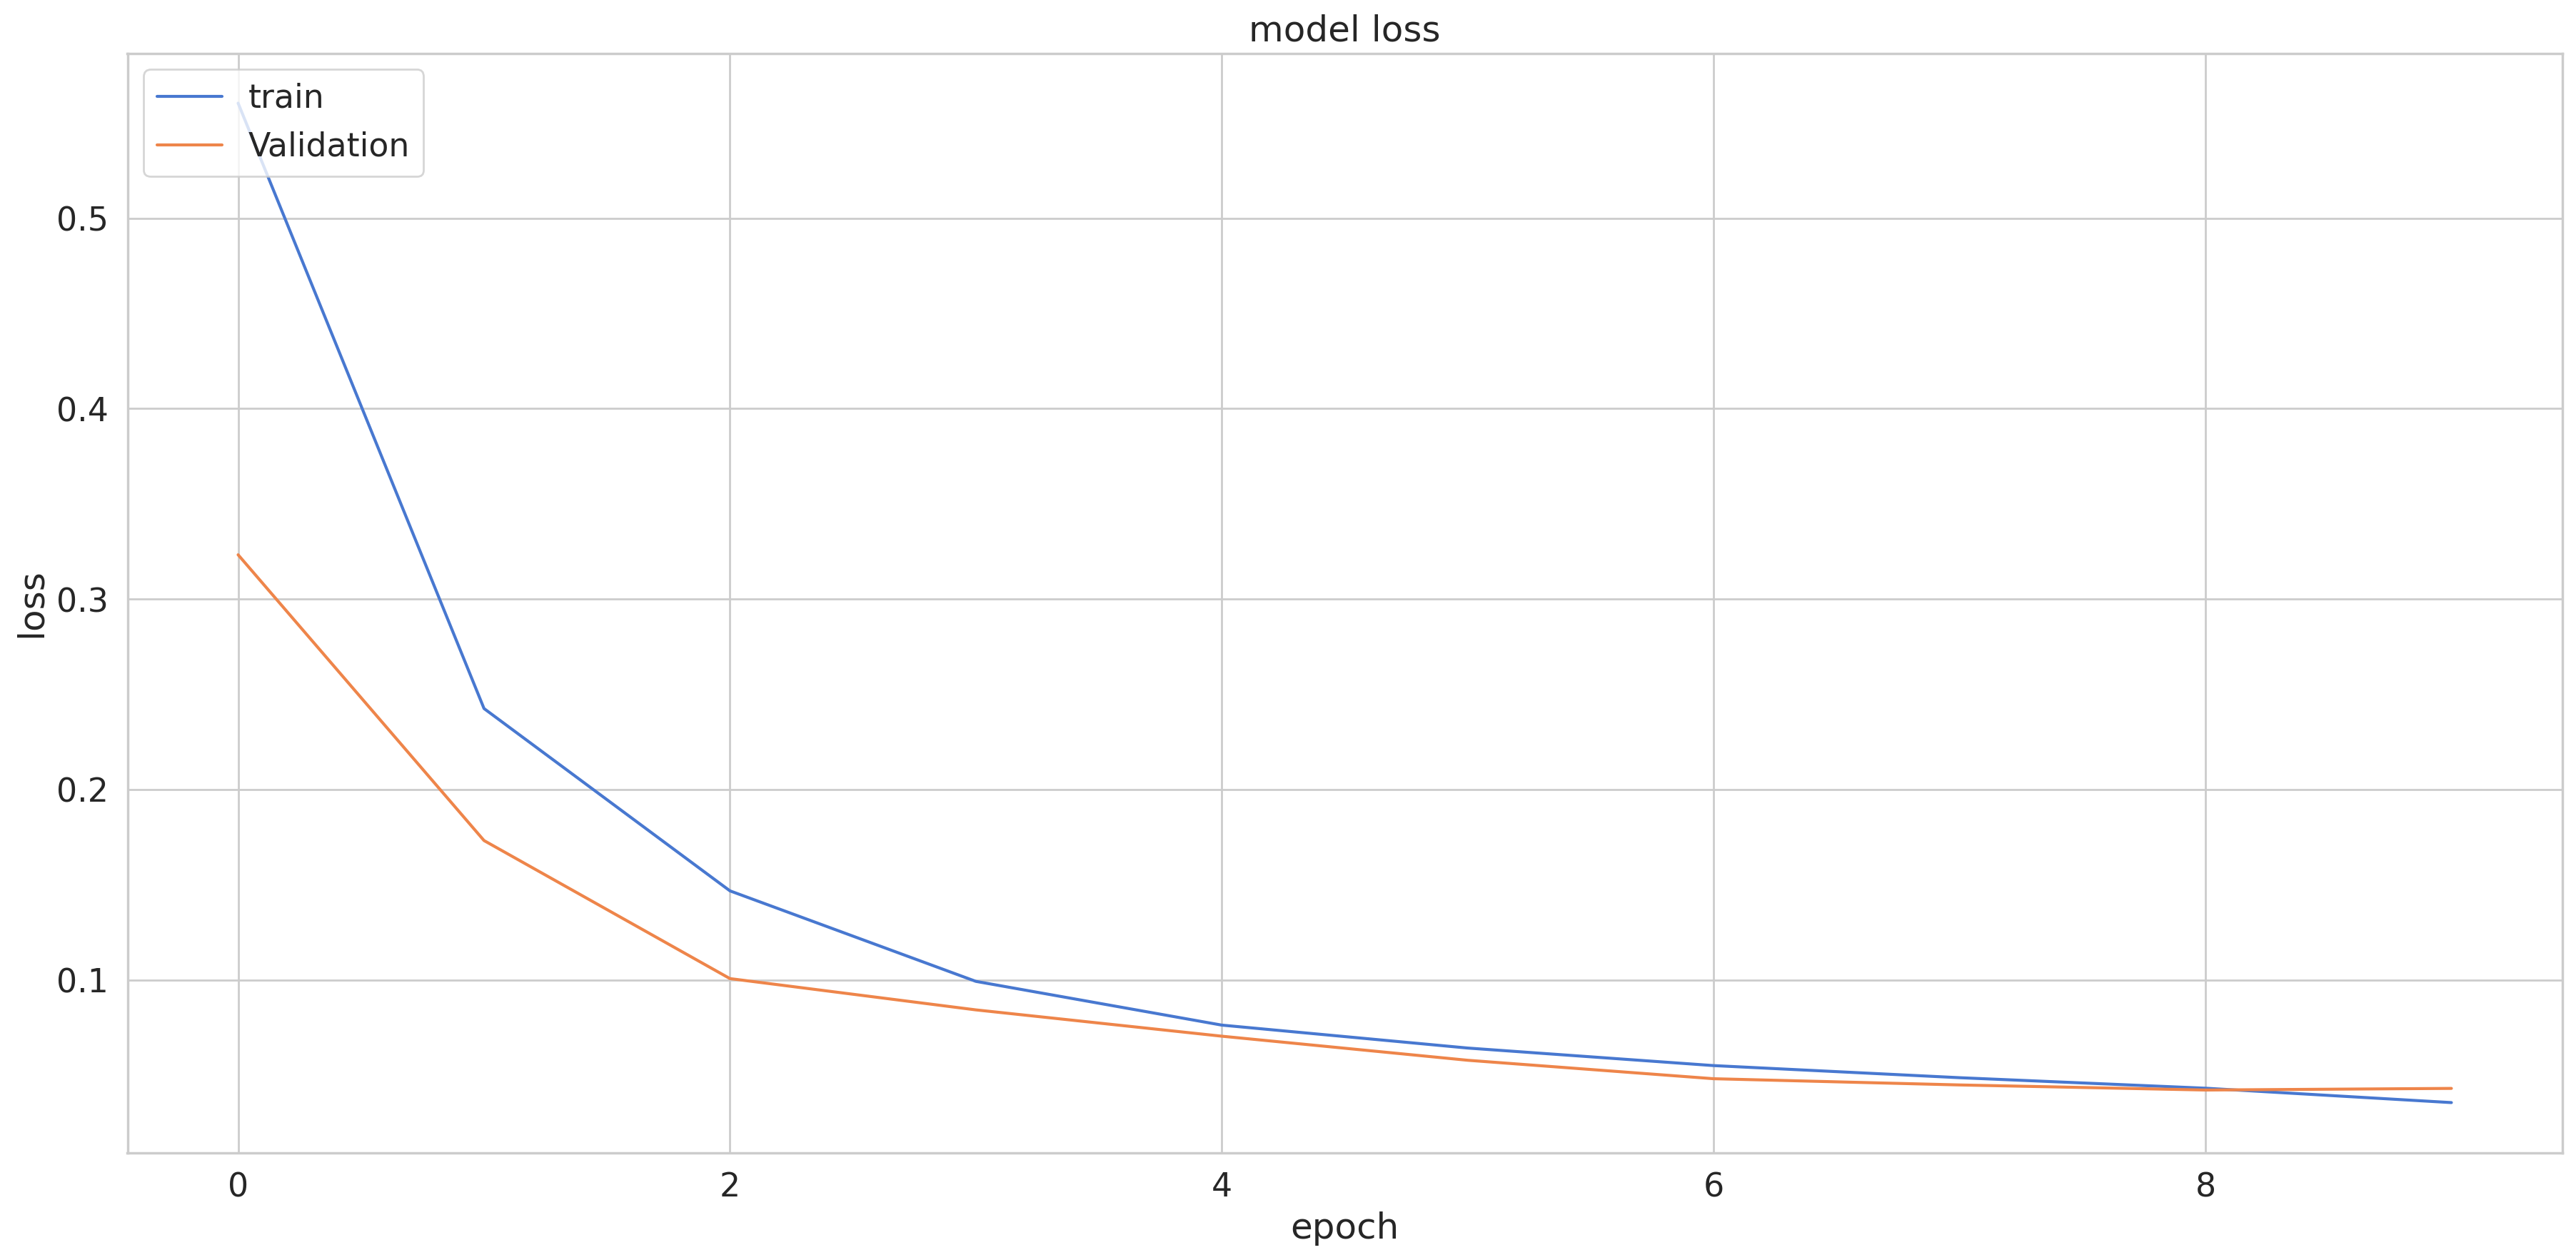

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

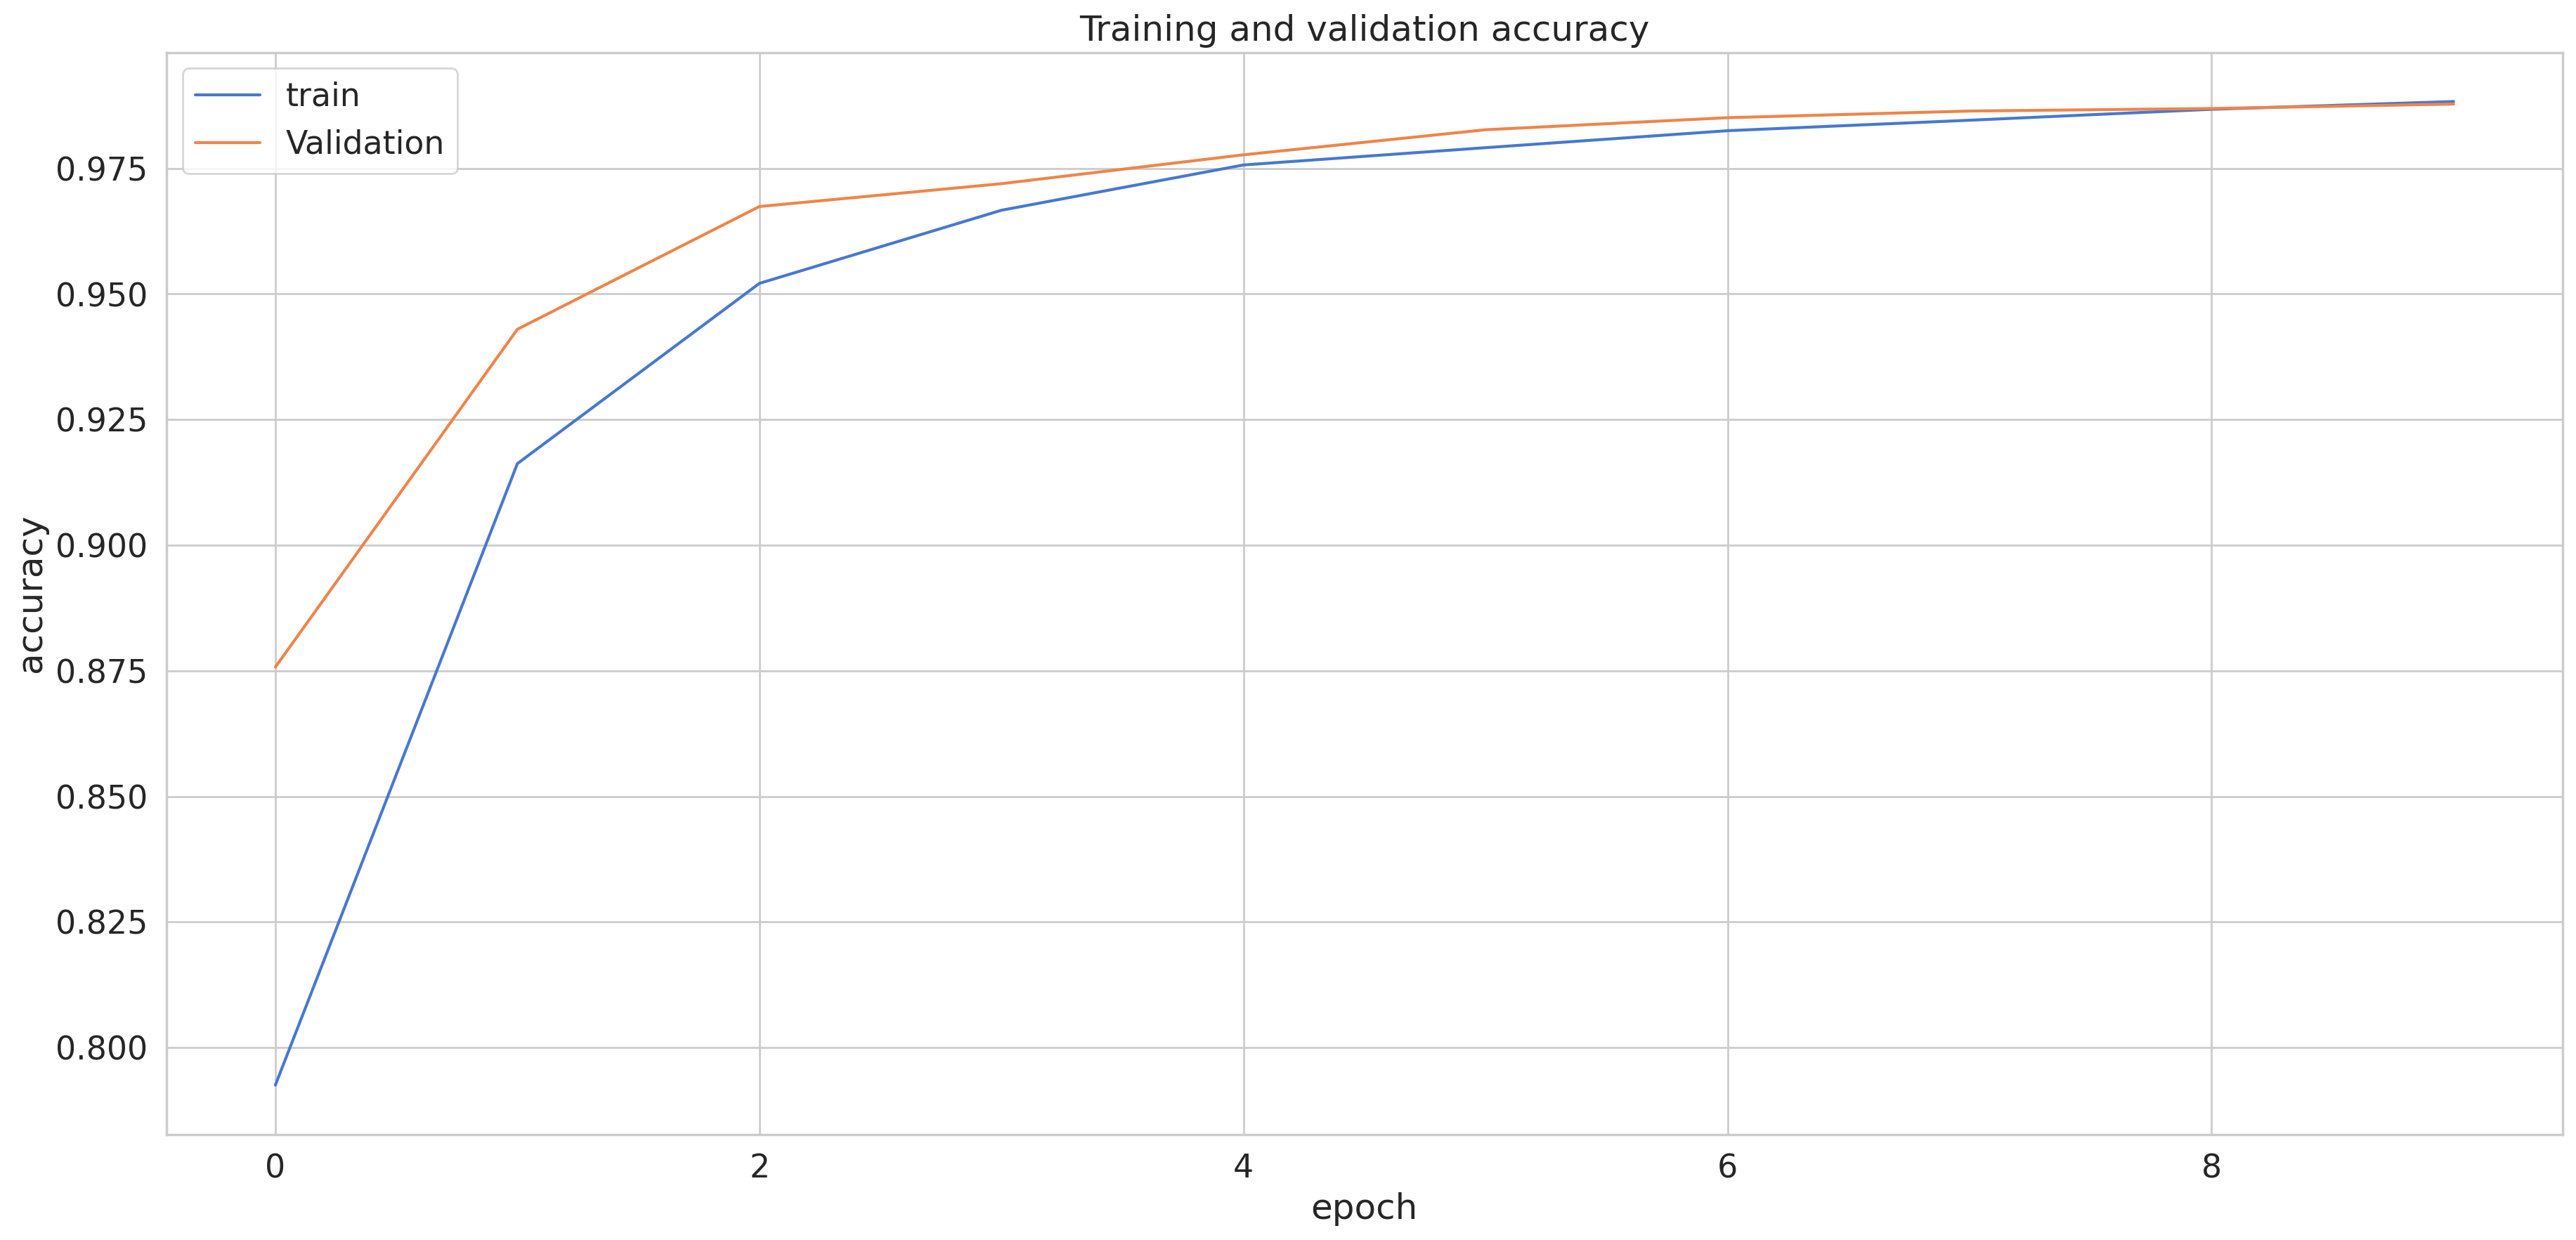

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 36s 56ms/step
f1_score =  0.9871958868509156
0.9871697731979593
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       1.00      0.99      1.00      6843
           2       0.97      0.96      0.97      2459
           3       0.95      0.97      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

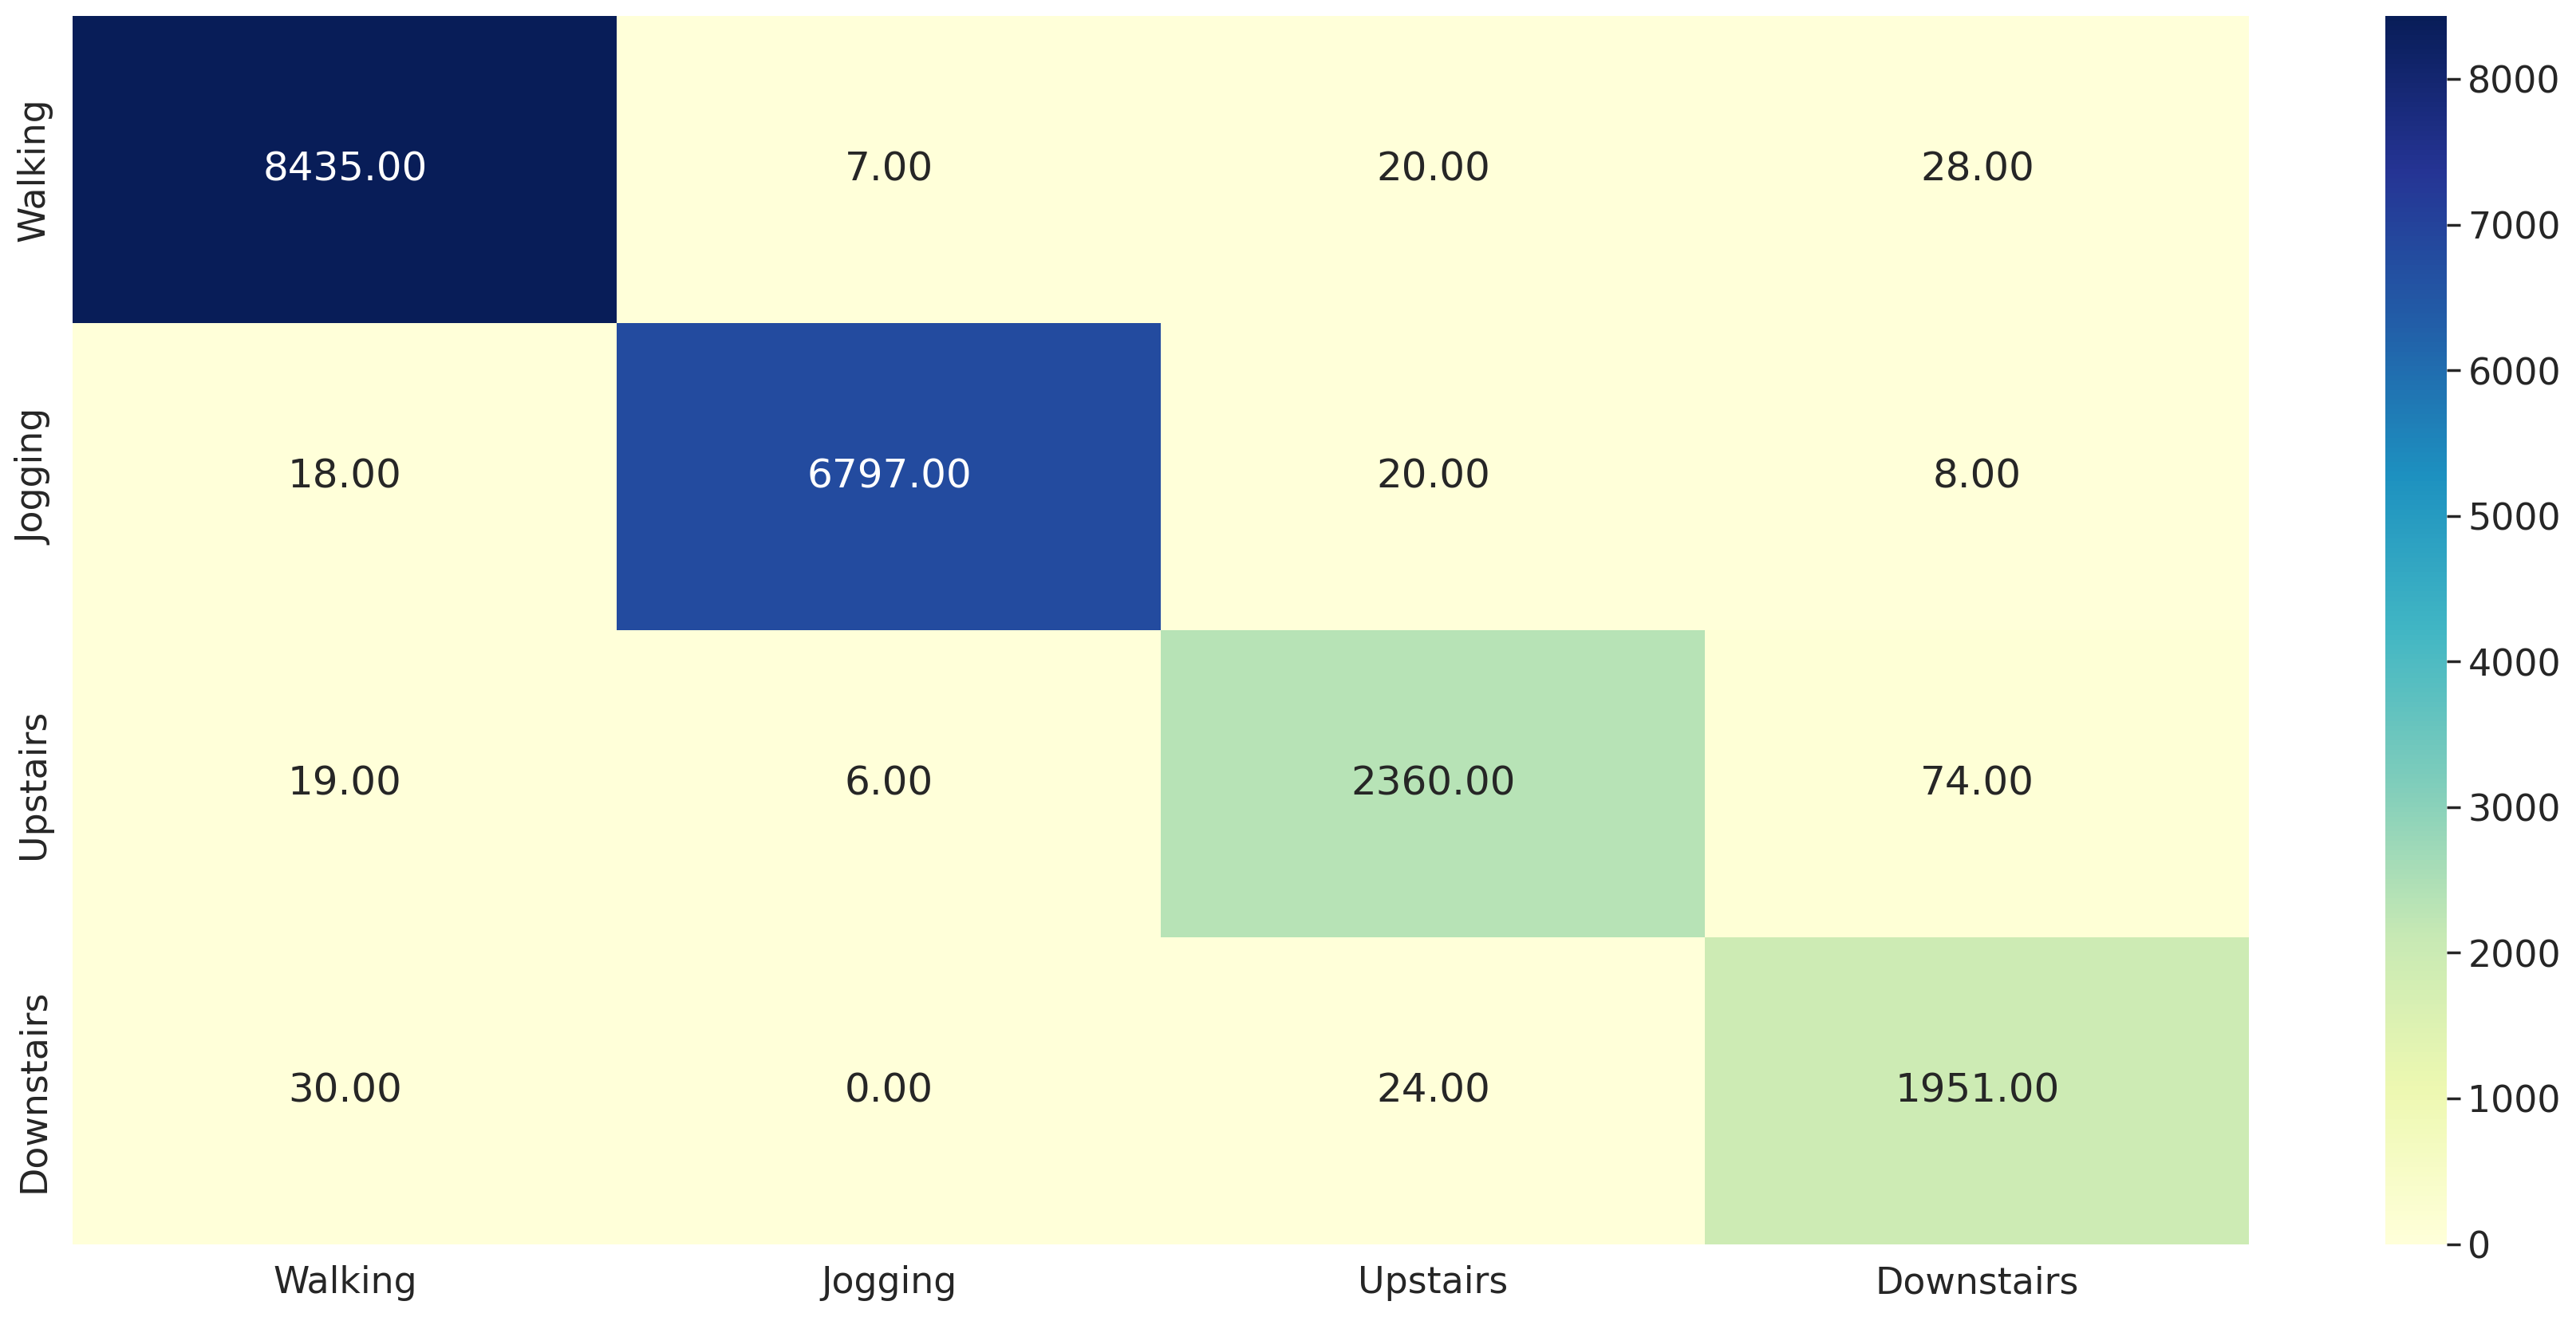

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [ ]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))


model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 128)           51072     
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_11 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_12 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_12 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_13 (GRU)                (None, 50, 128)          

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 374s 734ms/step - loss: 0.5578 - accuracy: 0.7941 - val_loss: 0.2872 - val_accuracy: 0.8975
Epoch 2/10
495/495 [==============================] - 388s 784ms/step - loss: 0.2305 - accuracy: 0.9229 - val_loss: 0.1710 - val_accuracy: 0.9434
Epoch 3/10
495/495 [==============================] - 386s 779ms/step - loss: 0.1483 - accuracy: 0.9521 - val_loss: 0.1087 - val_accuracy: 0.9668
Epoch 4/10
495/495 [==============================] - 373s 754ms/step - loss: 0.1033 - accuracy: 0.9666 - val_loss: 0.1039 - val_accuracy: 0.9668
Epoch 5/10
495/495 [==============================] - 371s 749ms/step - loss: 0.0816 - accuracy: 0.9740 - val_loss: 0.0699 - val_accuracy: 0.9768
Epoch 6/10
495/495 [==============================] - 374s 756ms/step - loss: 0.0655 - accuracy: 0.9788 - val_loss: 0.0556 - val_accuracy: 0.9830
Epoch 7/10
495/495 [==============================] - 371s 750ms/step - loss: 0.0564 - accuracy: 0.9824 - val_loss: 0.0571 -

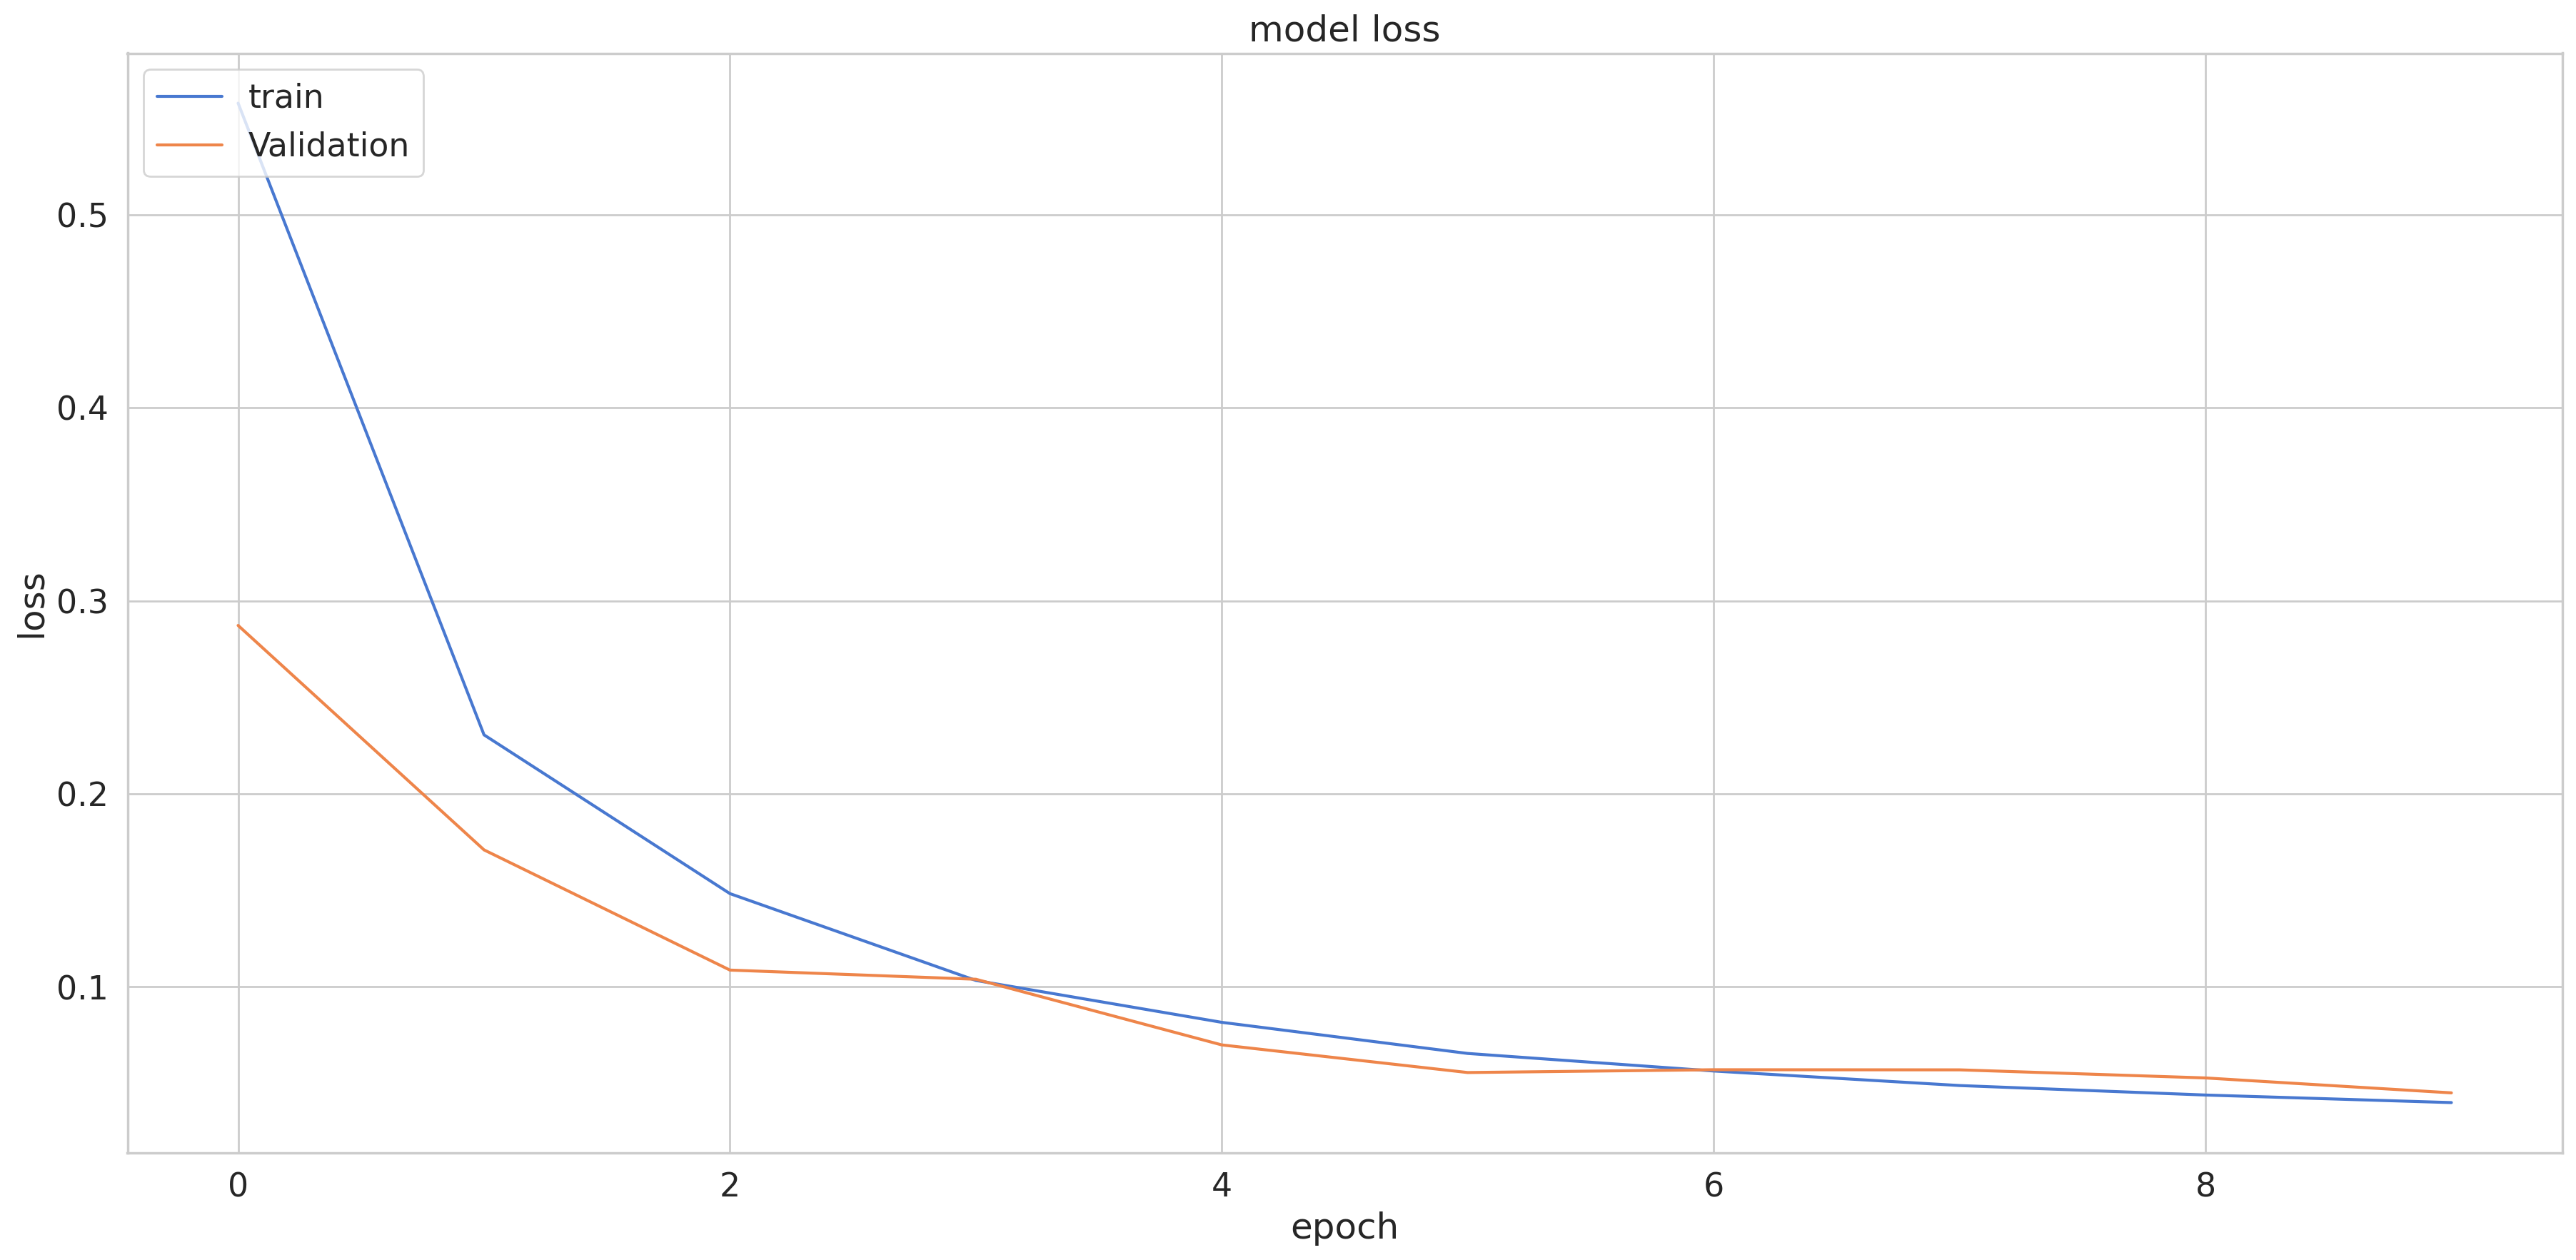

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

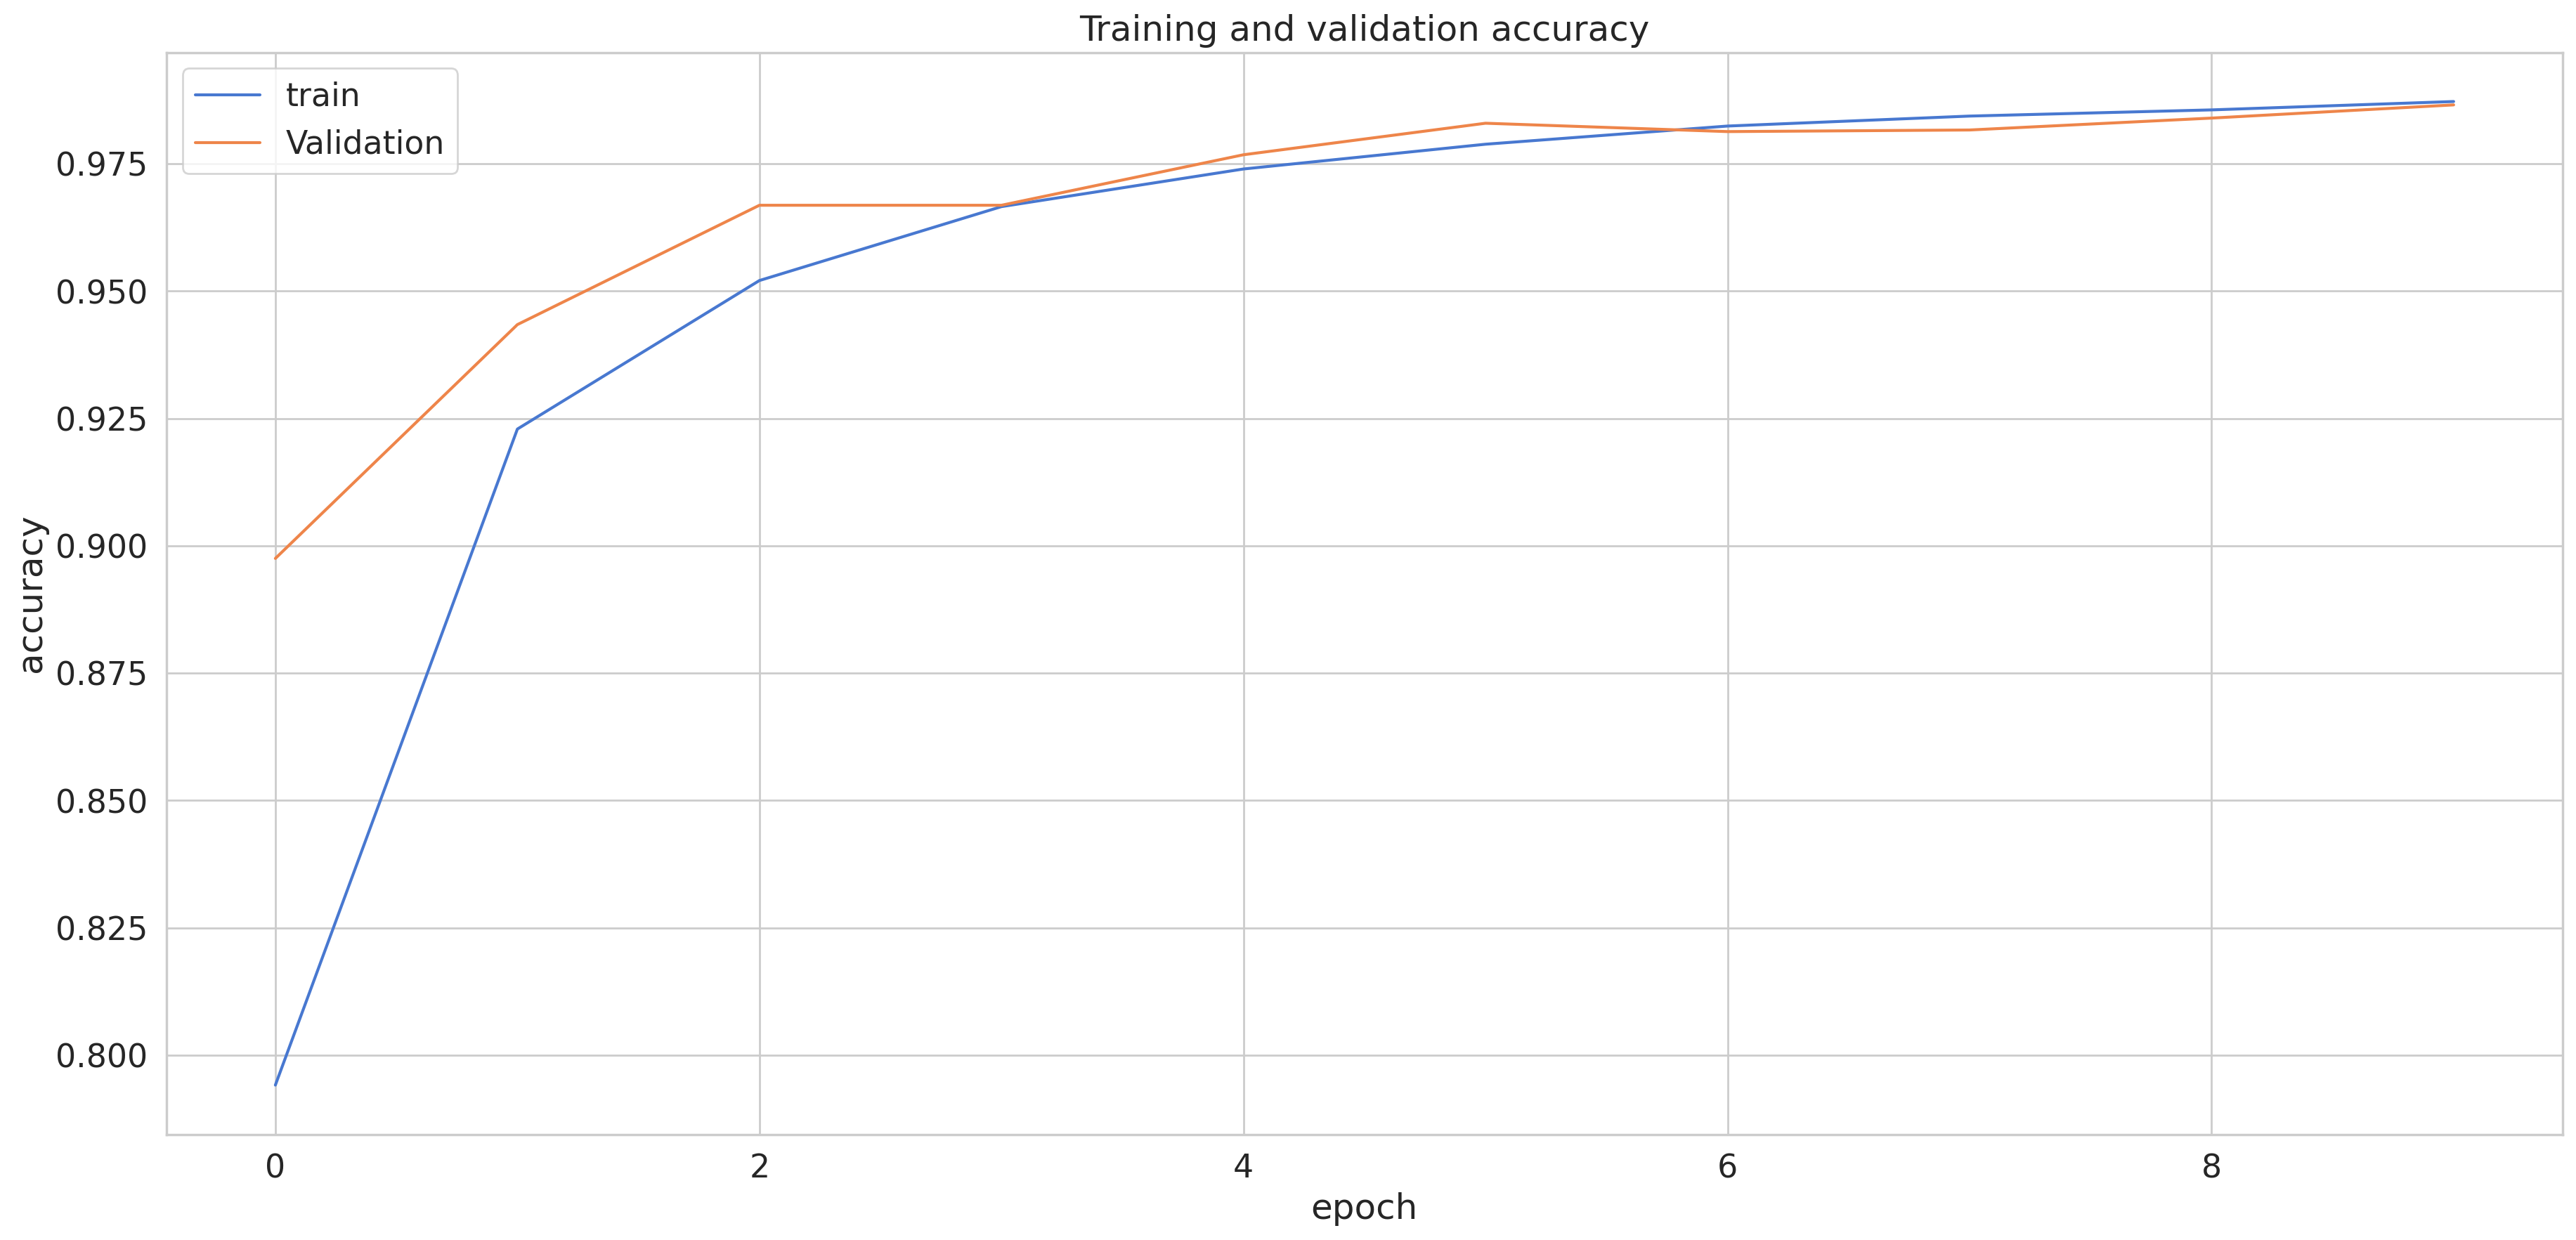

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 45s 71ms/step
f1_score =  0.98581841495142
0.9857554174874981
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       1.00      0.99      1.00      6843
           2       0.95      0.97      0.96      2459
           3       0.95      0.96      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.97      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

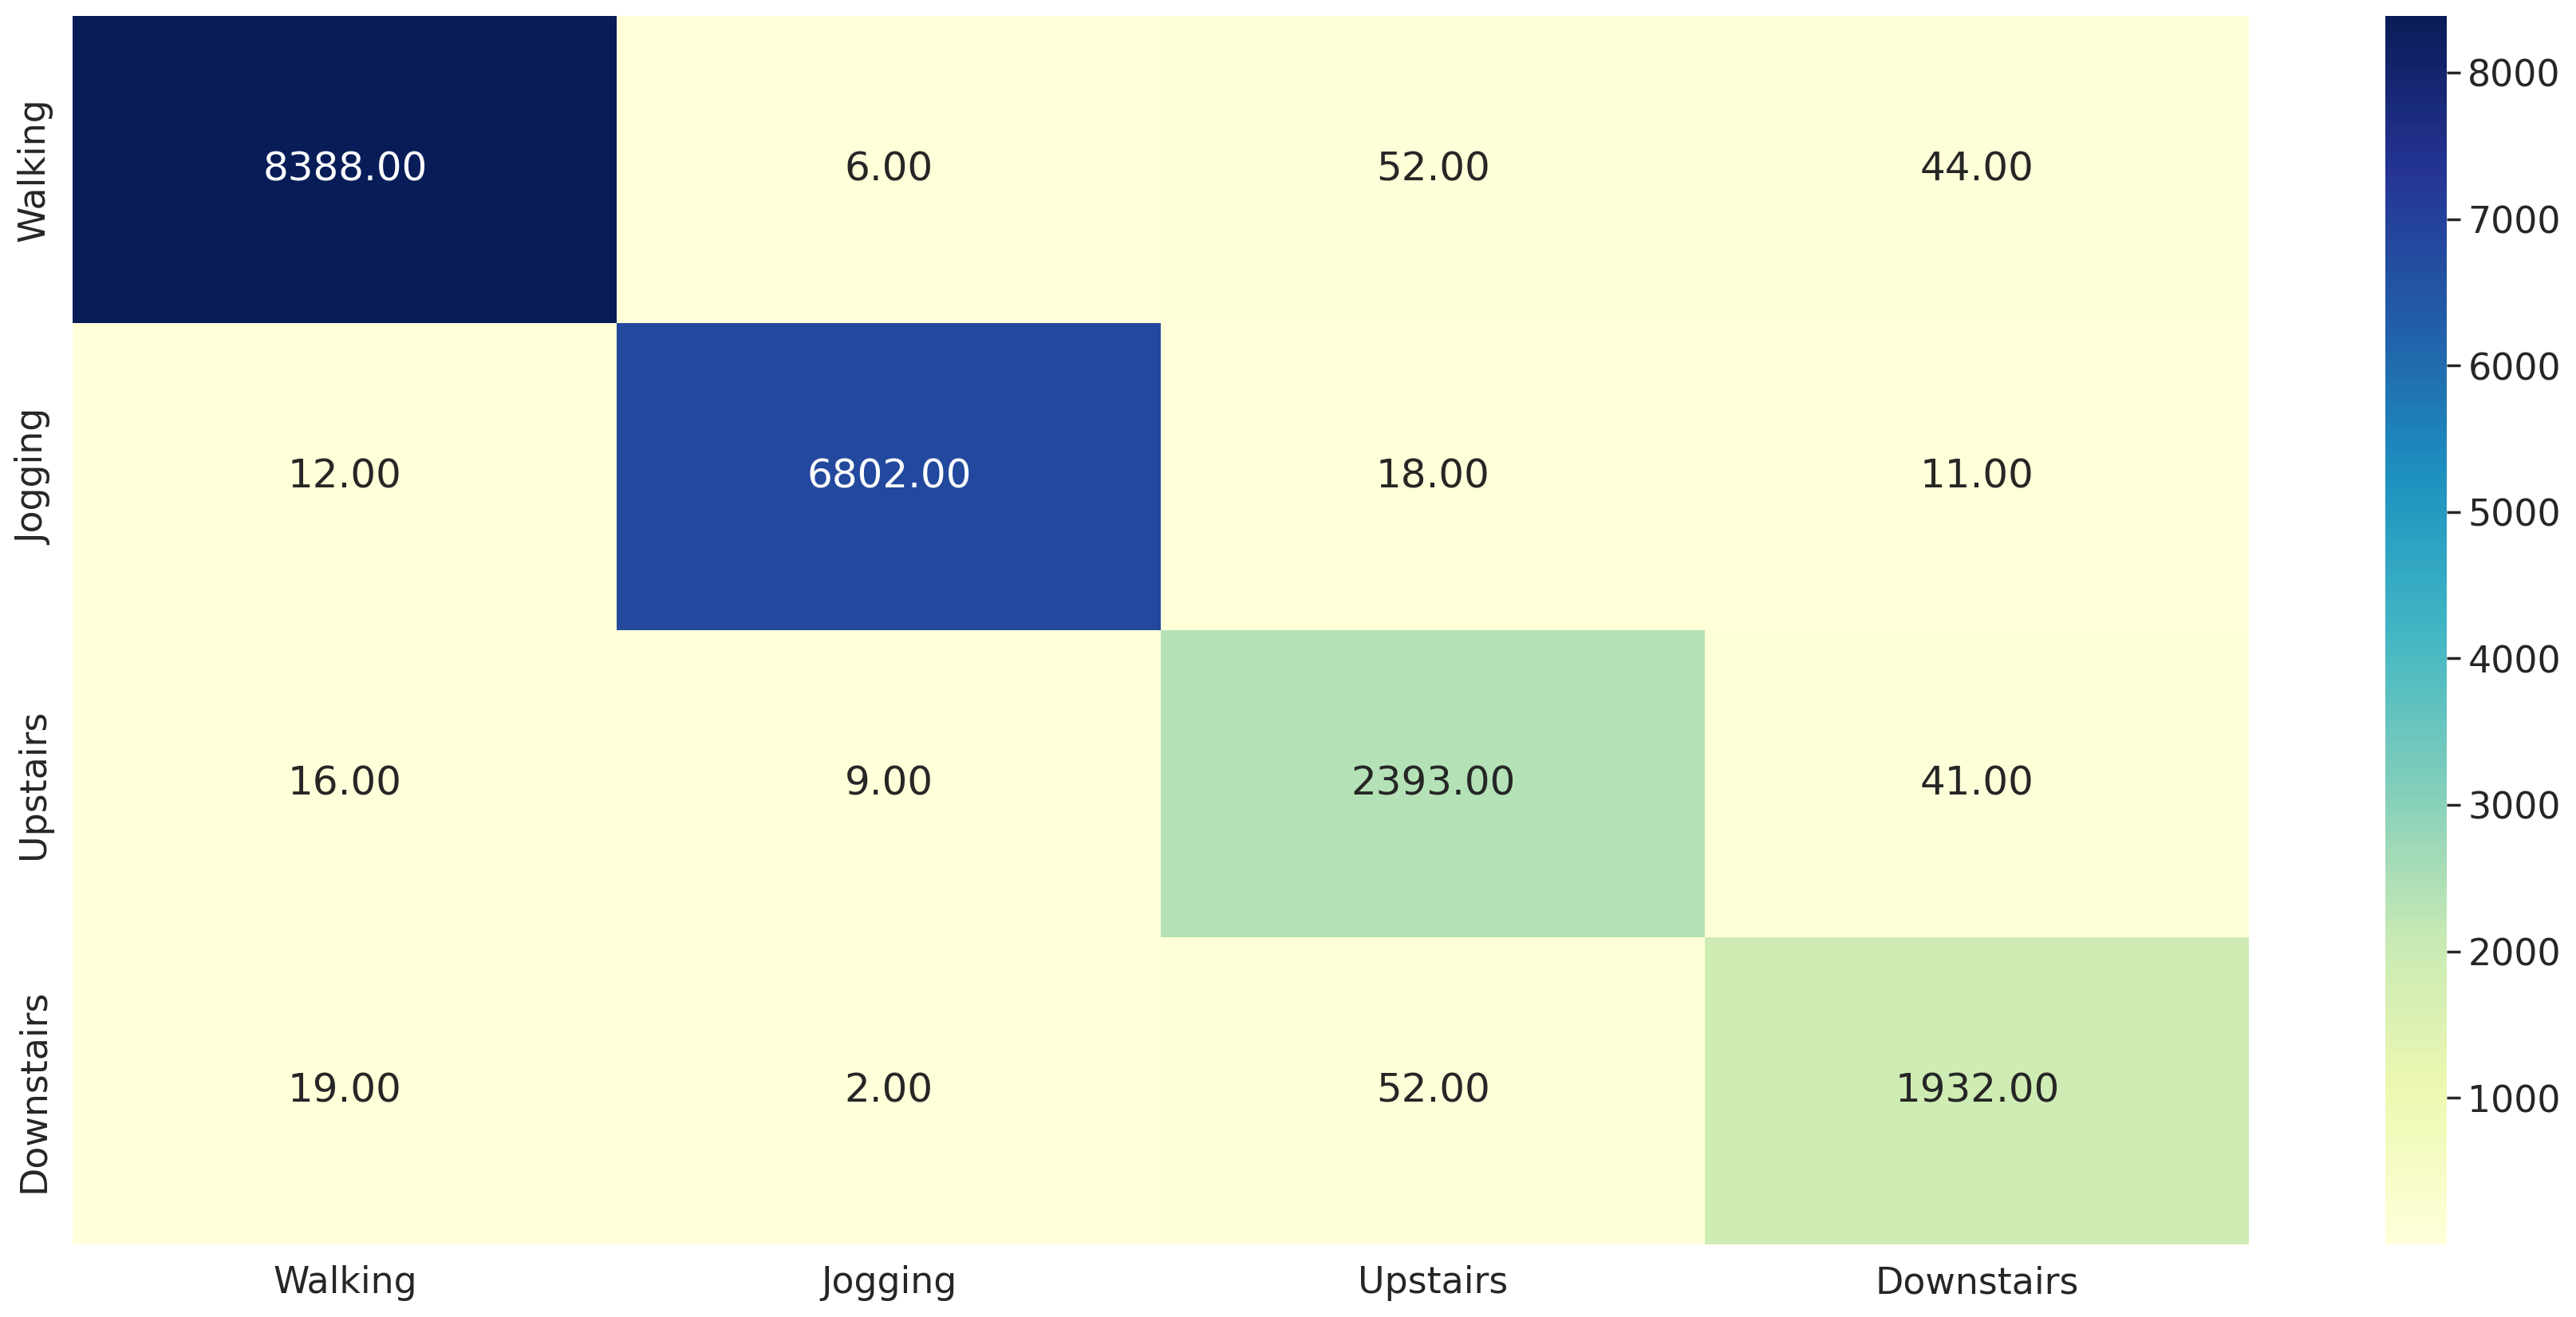

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')